# Identifying Subliminal Advertising in Wikipedia Articles

### Sven Ostertag

# Introduction

The internet is the greatest tool of information dissemination and consumption in history. It has thus become a critical means of advertising, promoting, or otherwise shifting opinions on points of interest such as products, ideologies, and historical events. This is expected, unavoidable, and often even beneficial to both the disseminating and the consuming party. However, such practices become deceptive, or at least morally questionable, when done in a manner such that information consumers are not aware that they are being advertised to. 

This project is conducted with an intention toward creating a tool which could help consumers quickly and reliably detect bias in a body of text. Conversely, an advertising entity would also gain value from this by being able to quickly identify when their methods are unsubtle. One could argue that if advertisers were more encouraged to advertise openly, rather than deceptively, they would be able to build better relationships with their customers to the benefit of both parties.
    
The scope of this project is limited to Wikipedia articles, from which there exists a convenient dataset to start with. The problem statement for this project is thus: 
    
How can we distinguish between Wikipedia articles that are promotional in tone and those that are not?
    
This project consists of first analyzing the data from several scopes, and then engineering an accurate and practical model for classifying Wikipedia articles as Good or Promotional.


Let us import the necessary packages:

In [1]:
#Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.decomposition import PCA

import pickle
import time
import math
import opendatasets
import spacy
from textatistic import Textatistic
from wordcloud import STOPWORDS
from spacy.glossary import GLOSSARY
from nltk.stem import PorterStemmer
from collections import defaultdict
from scipy import sparse

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import warnings
warnings.filterwarnings('ignore')

# Customizing Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data Cleaning

In [2]:
# Downloading the dataset from Kaggle.
opendatasets.download("https://www.kaggle.com/datasets/urbanbricks/wikipedia-promotional-articles")

good = pd.read_csv('wikipedia-promotional-articles/good.csv')
promotional = pd.read_csv('wikipedia-promotional-articles/promotional.csv')

Skipping, found downloaded files in ".\wikipedia-promotional-articles" (use force=True to force download)


This data is available on Kaggle under the title Wikipedia Promotional Articles. It is provided by the user urbanbricks, who claims that this data was acquired by webscraping Wikipedia’s own archives on Good and Promotional Tone articles. There are about 30,000 and 20,000 Good and Promotional articles in the dataset, respectively. The distinction between Good and Promotional is determined via a nomination process on Wikipedia involving at least two editors for each nomination. 

The data consists of two CSV files, one for Good articles and one for Promotional. The Good dataset contains the article text and URL in each row, and the Promotional dataset contains the same, but with the addition of labels for subsets of promotions. These additional columns are ignored, for simplicity.


In [3]:
# Printing original shapes
print(good.shape)
print(promotional.shape)

(30279, 2)
(23837, 7)


Good articles outnumber promotional ones. There is text and URL data in good, but the URL is out of the scope of this study, and will be ignored. The promotional articles contain 5 extra features for promotional subcategory.

In [4]:
print(good.duplicated().sum().sum())
print(promotional.duplicated().sum().sum())
print(good.isna().sum().sum())
print(promotional.isna().sum().sum())

0
0
0
0


There are no duplicates nor null values in the dataset.

Let us take a look at an example text from the Good dataframe.

In [5]:
# Sample text
good.iloc[1234]['text']

"The 2013 Emirates Cup was a pre season football friendly tournament hosted by Arsenal at its home ground, the Emirates Stadium in London. It was the sixth Emirates Cup, an invitational competition inaugurated in 2007. Held on the weekend of 34 August 2013, the participants were Arsenal, Porto, Napoli, and Galatasaray. The 2013 edition marked the resumption of the Emirates Cup as the tournament took a hiatus in 2012 due to the Summer Olympics. The competition follows a point scoring system much like the Amsterdam Tournament, whereby each team plays two matches, with three points awarded for a win, one point for a draw and none for a loss. It also reverted to system whereby each goal was awarded with a point. Arsenal did not face Porto, and Napoli did not play against Galatasaray. The first day saw Galatasaray defeat Porto by a single goal, while Arsenal came from two goals down to draw against Napoli. Didier Drogba scored twice for Galatasaray against Arsenal to ensure the Turkish club

The text looks as expected for the most part. The end simply says "Specific General", with no period, and so looks a bit like a mistake. These kinds of occurences would be hard to identify for removal, and since they take up so little of the text, I think it is safe to ignore them.

The rest of the text itself looks like a standard well written Wikipedia article.

In [6]:
# Artifact text
good[good['text'].str.contains('\.mw')]['text'][104]

".mw parser output .RMbox box shadow 0 2px 2px 0 rgba 0,0,0,.14 ,0 1px 5px 0 rgba 0,0,0,.12 ,0 3px 1px 2px rgba 0,0,0,.2 .mw parser output .RMinline float none width 100 margin 0 border none .mw parser output table.routemap padding 0 border 0 border collapse collapse background transparent white space nowrap line height 1.2 margin auto .mw parser output table.routemap .RMcollapse margin 0 border collapse collapse vertical align middle .mw parser output table.routemap .RMreplace margin 0 border collapse collapse vertical align middle position absolute bottom 0 .mw parser output table.routemap .RMsi display inline font size 90 .mw parser output table.routemap .RMl1 padding 0 3px text align left .mw parser output table.routemap .RMr1 padding 0 3px text align right .mw parser output table.routemap .RMl text align right .mw parser output table.routemap .RMr text align left .mw parser output table.routemap .RMl4 padding 0 3px 0 0 text align left .mw parser output table.routemap .RMr4 padding

At the top of this text, one can see plenty of words that suggest coding or webscraping artifacts. Either way, I would rather not deal with them, and so I will remove rows with these kinds of strings.

In [7]:
# Sample promotional text
promotional.iloc[1234]['text']

"The Asbestos Disease Awareness Organization ADAO is the largest independent nonprofit in the U.S. dedicated to preventing asbestos exposure, eliminating asbestos related diseases such as mesothelioma, and protecting asbestos victims' civil rights through education, advocacy and community initiatives. ADAO was founded by Linda Reinstein and Doug Larkin in 2004 and is headquartered in Redondo Beach, California. It is led by three boards Board of Directors, Science Advisory Board, and Prevention Advisory Board , as well as a nationwide State Leadership Team made up of asbestos victims and advocates. Linda Reinstein, ADAO President and Co Founder, has been invited to and presented at legislative hearings and medical symposiums in more than 20 countries including being invited to testify before the U.S. Senate and House of Representatives. In addition to the conference, ADAO annually hosts the Global Asbestos Awareness Week from April 17. Since 2005, the U.S. Senate has unanimously passed 

Here is an example of a promotional text. This one seems to promote both an organization and an individual more than an informational article should.

In [8]:
# Sample short promotional text
print(promotional.iloc[18455]['text'],'\n')
print(promotional.iloc[101]['text'],'\n')
print(promotional.iloc[23821]['text'],'\n')
print(promotional.iloc[12070]['text'])

Iklil Sati was a Jordanian Ambassador. 

ART21 TV Armenian 21 The Only Cultural Television company of Armenia 

The ZTE Tania is the first Windows Phone device manufactured by ZTE. The ZTE Tania is a Windows Phone device which is meant to serve the lower end market. The phone has a 4.3 inch WVGA 800x480 TN LCD screen, 5 megapixel autofocus camera, and 4 GB of storage. 

Note This list is incomplete and does not include Tagalog movies and some of the box office figures for Hollywood movies released from January and February 2015 have NO DATA on Box Office Mojo and The Numbers.


Here are a few examples of the shorter texts with promotional tags. There seems to be much variety between them, some being really short, one looking like the leftover notes of an editor's markup.

Let us remove the articles with obvious artifacts, and add full stops to the ends of all rows without them.

In [9]:
# Removing documents with the following artifacts
artifacts = '\.mw|\.1em|\.cs1|parser output|\.citation|\.refbegin|\.RMbox|\.RMinline|\.routemap|\.RMsi'
good = good[~good['text'].str.contains(artifacts)].reset_index(drop = True)
promotional = promotional[~promotional['text'].str.contains(artifacts)].reset_index(drop = True)

# Adding full stops at the ends of articles which don't have them
# This adjustment needs to be made to appease Textatistic
promotional['text'] = promotional['text'].apply(lambda txt: txt + '.' if txt[-1] != '.' else txt)
good['text'] = good['text'].apply(lambda txt: txt + '.' if txt[-1] != '.' else txt)

# Dropping this, also to appease Textatistic - it has a 101 character long word in it, which causes an error
good=good.drop(good.index[9749])

In [10]:
# Printing new shapes
print(good.shape)
print(promotional.shape)

(29570, 2)
(23606, 7)


In [11]:
# Printing total datapoints before and after
print(30279 + 23837)
print(29570 + 23606)

54116
53176


We've discarded merely a small fraction of our data by this point.

Let us take a look at promotional subcategories:

In [12]:
promotional[['advert', 'coi', 'fanpov', 'pr', 'resume']].sum()/promotional.shape[0]

advert    0.794713
coi       0.089850
fanpov    0.062357
pr        0.063628
resume    0.091163
dtype: float64

The Promotional table contains subcategory labels. Most articles are adverts, and labels aren't mutually exclusive. It's useful to keep in mind that most of these will be advertisements of some sort, but we will remove these labels to simplify our model.

In [13]:
promotional = promotional.drop(columns = ['advert', 'coi', 'fanpov', 'pr', 'resume'])

Finally, we will label our two DataFrames based on their promotional status.

In [14]:
good['is_not_promo'] = 1
promotional['is_not_promo'] = 0

# Exploratory Data Analysis

We will explore our data by looking at N-grams and engineering features from the textual data.

In [15]:
# The below N-gram generation and plotting code is a modified version of what can be found here:
# https://www.kaggle.com/code/gunesevitan/nlp-with-good-tweets-eda-cleaning-and-bert
# Written originally by Gunes Evitan

def generate_ngrams(text, n_gram=1):
    """Function that takes in text and generates tokenized n-grams"""
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

# Create dummy column to remove punctuation from
good['text_no_punctuation'] = good['text'].str.replace('[^\w\s]','')
promotional['text_no_punctuation'] = promotional['text'].str.replace('[^\w\s]','')

# Generate Unigrams
good_unigrams = defaultdict(int)
promotional_unigrams = defaultdict(int)

for text in good['text_no_punctuation']:
    for word in generate_ngrams(text):
        good_unigrams[word] += 1
        
for text in promotional['text_no_punctuation']:
    for word in generate_ngrams(text):
        promotional_unigrams[word] += 1
        
df_good_unigrams = pd.DataFrame(sorted(good_unigrams.items(), key=lambda x: x[1])[::-1])
df_promotional_unigrams = pd.DataFrame(sorted(promotional_unigrams.items(), key=lambda x: x[1])[::-1])

# Generate Bigrams
good_bigrams = defaultdict(int)
promotional_bigrams = defaultdict(int)

for text in good['text_no_punctuation']:
    for word in generate_ngrams(text, n_gram=2):
        good_bigrams[word] += 1
        
for text in promotional['text_no_punctuation']:
    for word in generate_ngrams(text, n_gram=2):
        promotional_bigrams[word] += 1
        
df_good_bigrams = pd.DataFrame(sorted(good_bigrams.items(), key=lambda x: x[1])[::-1])
df_promotional_bigrams = pd.DataFrame(sorted(promotional_bigrams.items(), key=lambda x: x[1])[::-1])

# Generate Trigrams
good_trigrams = defaultdict(int)
promotional_trigrams = defaultdict(int)

for text in good['text_no_punctuation']:
    for word in generate_ngrams(text, n_gram=3):
        good_trigrams[word] += 1
        
for text in promotional['text_no_punctuation']:
    for word in generate_ngrams(text, n_gram=3):
        promotional_trigrams[word] += 1
        
df_good_trigrams = pd.DataFrame(sorted(good_trigrams.items(), key=lambda x: x[1])[::-1])
df_promotional_trigrams = pd.DataFrame(sorted(promotional_trigrams.items(), key=lambda x: x[1])[::-1])

good = good.drop(columns = ['text_no_punctuation'])
promotional = promotional.drop(columns = ['text_no_punctuation'])

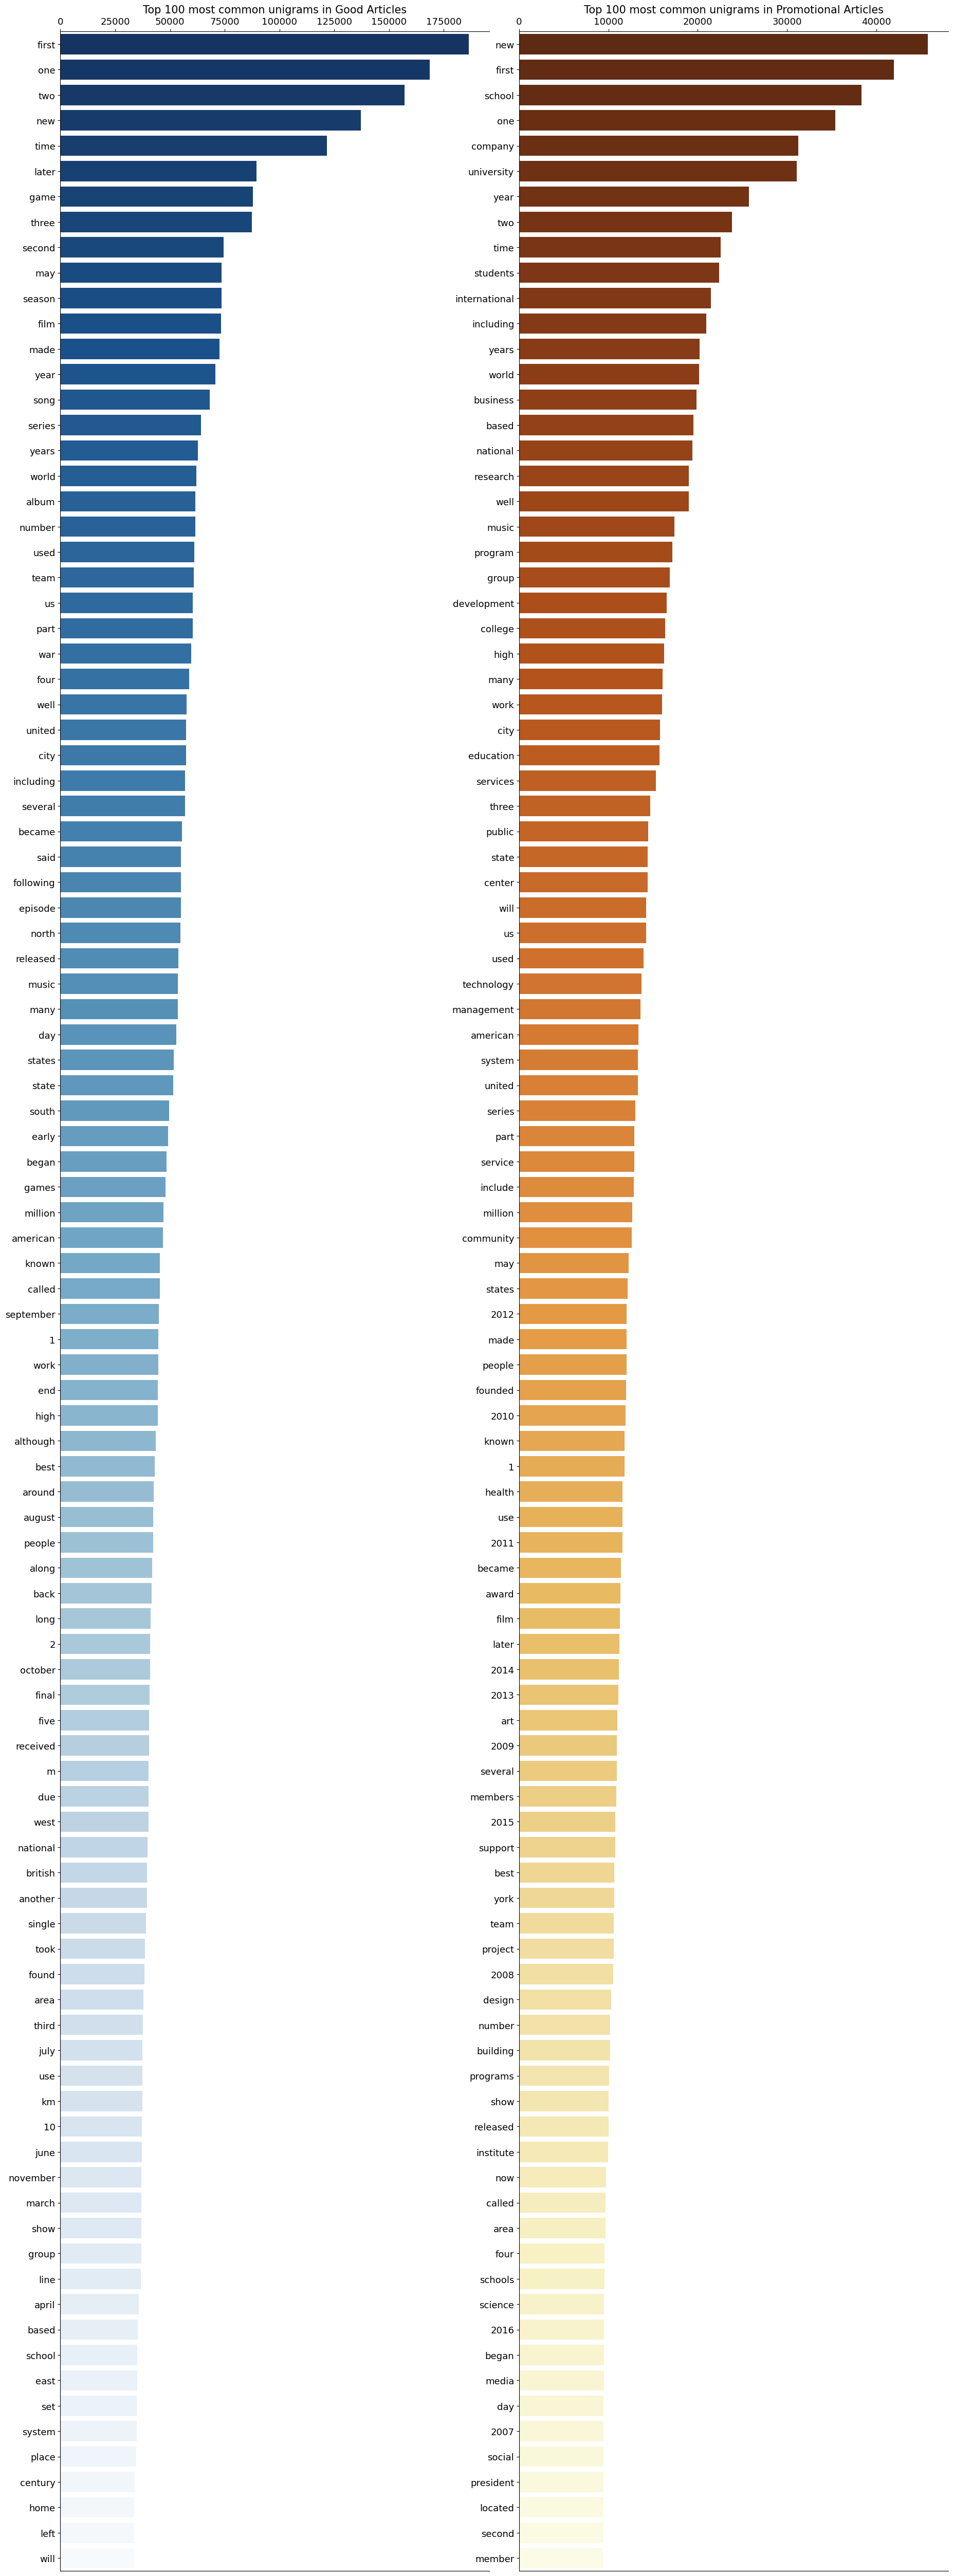

In [16]:
# Plotting top 100 Unigrams

N = 100

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

a = sns.barplot(y=df_good_unigrams[0].values[:N], x=df_good_unigrams[1].values[:N], ax=axes[0], palette = 'Blues_r')
b = sns.barplot(y=df_promotional_unigrams[0].values[:N], x=df_promotional_unigrams[1].values[:N], ax=axes[1], palette = 'YlOrBr_r')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)
    
a.xaxis.set_ticks_position('top')
b.xaxis.set_ticks_position('top')
axes[0].set_title(f'Top {N} most common unigrams in Good Articles', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Promotional Articles', fontsize=15)
plt.show()

What sticks out to me here is that we see several references to education and business related topics on the right, whereas the unigrams on the left contain terms that are somewhat more historical and miscellaneous in nature.

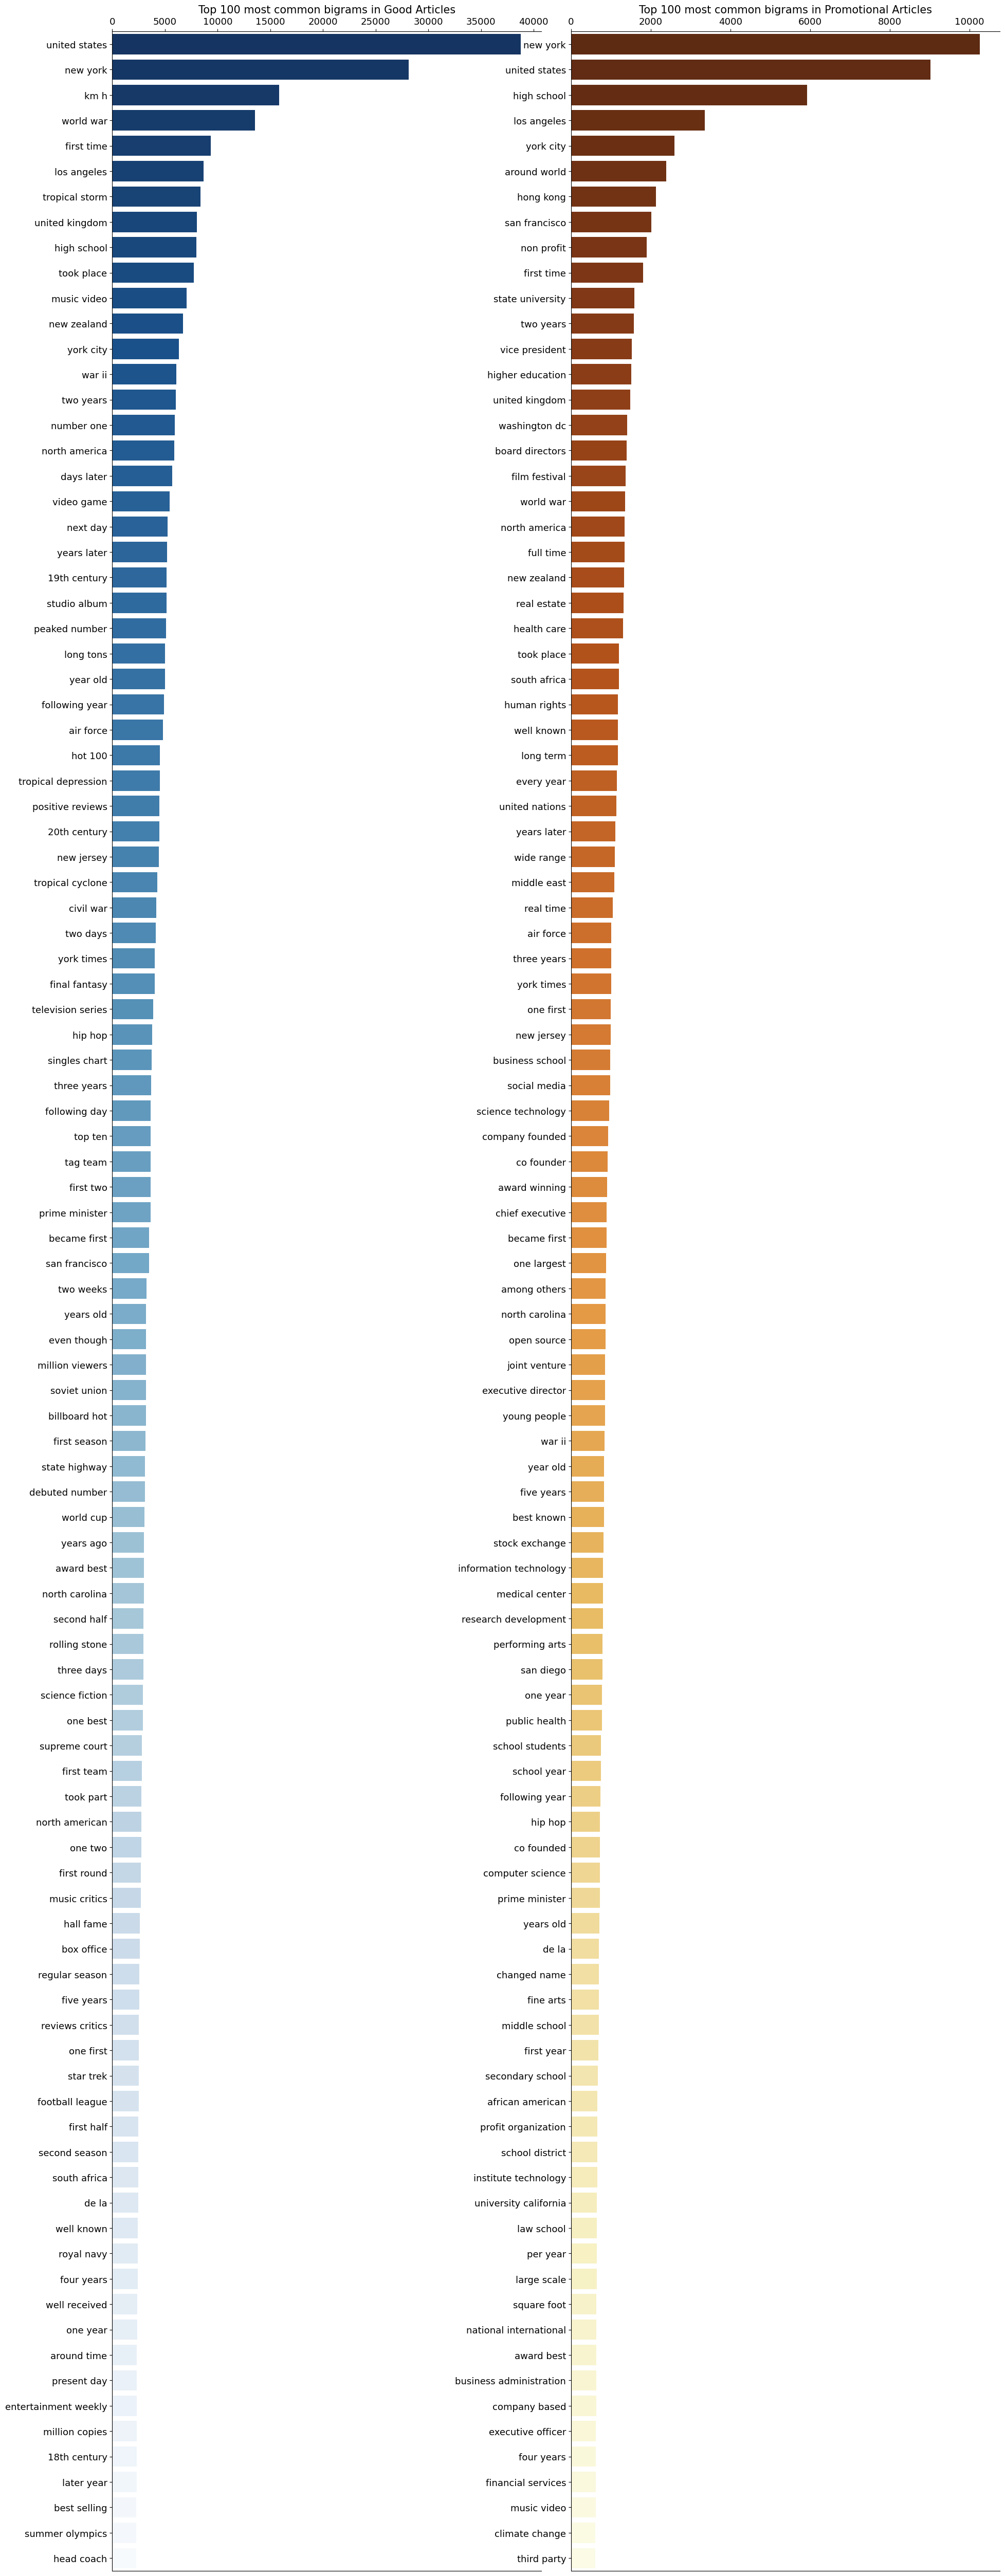

In [17]:
# Plotting top 100 Bigrams

N = 100

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

a = sns.barplot(y=df_good_bigrams[0].values[:N], x=df_good_bigrams[1].values[:N], ax=axes[0], palette = 'Blues_r')
b = sns.barplot(y=df_promotional_bigrams[0].values[:N], x=df_promotional_bigrams[1].values[:N], ax=axes[1], palette = 'YlOrBr_r')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

a.xaxis.set_ticks_position('top')
b.xaxis.set_ticks_position('top')
axes[0].set_title(f'Top {N} most common bigrams in Good Articles', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Promotional Articles', fontsize=15)

plt.show()

Here the lines are a bit more blurred, but we see some similarities to the unigrams. On the right we have terms such as higher education, state university, board directors, non profit, research development, and business school, while on the left we see terms such as tropical storm, music video, and km h.

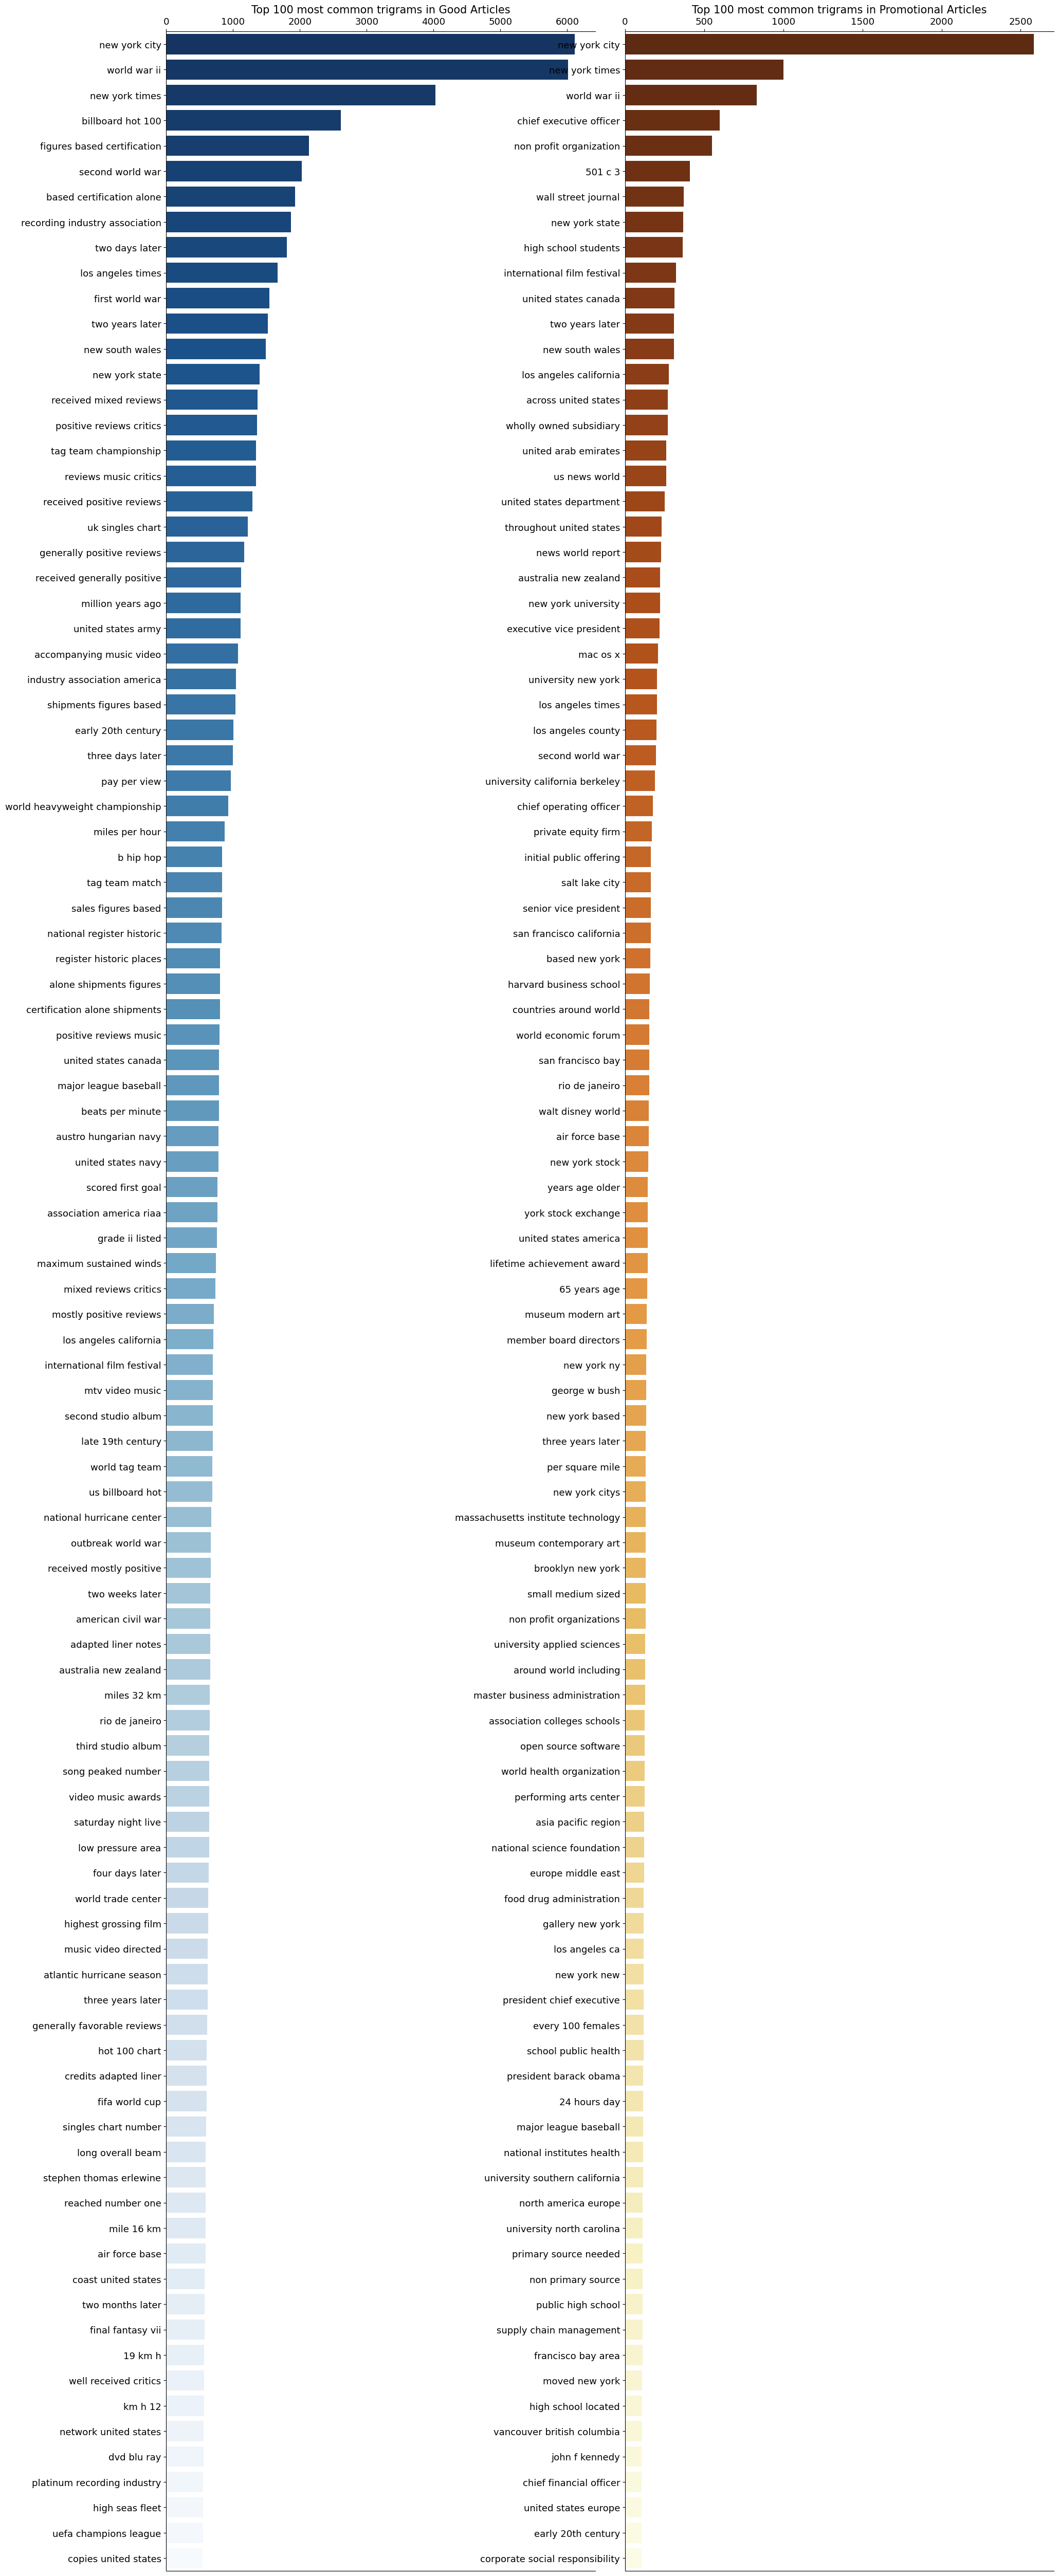

In [18]:
# Plotting top 100 Trigrams

N = 100

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

a = sns.barplot(y=df_good_trigrams[0].values[:N], x=df_good_trigrams[1].values[:N], ax=axes[0], palette = 'Blues_r')
b = sns.barplot(y=df_promotional_trigrams[0].values[:N], x=df_promotional_trigrams[1].values[:N], ax=axes[1], palette = 'YlOrBr_r')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)
    
a.xaxis.set_ticks_position('top')
b.xaxis.set_ticks_position('top')
axes[0].set_title(f'Top {N} most common trigrams in Good Articles', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Promotional Articles', fontsize=15)

plt.show()

Before cleaning, we would have seen several artifact triplets here, which gave away their existence. With the remaining trigrams, we see again the similar pattern before of various topics on the left and business/education oriented terms on the right.

In [29]:
# Preparing Spacy
spacy.prefer_gpu()
sp = spacy.load('en_core_web_sm')

# Making a tag counter
extracted_feature_dict = {'CARDINAL': 0, 'DATE': 0, 'EVENT': 0,
                          'FAC': 0, 'GPE': 0, 'LANGUAGE': 0,
                          'LAW': 0, 'LOC': 0, 'MONEY': 0,
                          'NORP': 0, 'ORDINAL': 0, 'ORG': 0,
                          'PERCENT': 0, 'PERSON': 0, 'PRODUCT': 0,
                          'QUANTITY': 0, 'TIME': 0, 'WORK_OF_ART': 0,
                          'Num Entities': 0, 'Unique Entities': 0}

# Creating an empty glossary, for each row
for key in GLOSSARY:
    extracted_feature_dict[key] = 0

# Helper function to extract features from Spacy object
def extract_features(text):
    """Takes in a spacy processed text object and returns a counting dictionary with various linguistic features"""
    
    ef_d = extracted_feature_dict.copy()

    # POS counting
    for token in text :
        ef_d[token.pos_] = ef_d[token.pos_] + 1

    # NER counting
    for ENT in text.ents :
        ef_d[ENT.label_] = ef_d[ENT.label_] + 1
    ef_d['Num Entities'] = len(text.ents)
#     This could be put back in, but refitting for some parts would need to be done
#     ef_d['Unique Entities'] = len(set(text.ents))

    return ef_d

def generate_meta_features(df, index):
    """Takes a DataFrame to generate meta features from, and an index to print progress into the console"""
    
    print('Starting ' + str(index))

    # char_count
    df['char_count'] = df['text'].apply(len)

    # sentences
    # rough estimate, since '. ' doens't always appear as a full stop.  +1 for the last sentence.
    df['sentences'] = df['text'].apply(lambda txt: 1 + txt.count('. ')) 

    # Creating list versions of the texts
    df['text_list'] = df['text'].apply(lambda txt: txt.split(' '))

    # word_count
    df['word_count'] = df['text_list'].apply(len)

    # unique_word_count
    df['unique_word_count'] = df['text_list'].apply(lambda txt: len(set(txt)))

    # stop_word_count
    df['stop_word_count'] = df['text_list'].apply(lambda txt: len([word for word in txt if word.lower() in STOPWORDS]))

    # mean_word_length
    df['mean_word_length'] = df['text_list'].apply(lambda txt: np.mean([len(word) for word in txt]))

    # readability_scores
    print('Textatistic Starting ' + str(index))
    df['readability_scores'] = df['text'].apply(lambda txt: Textatistic(txt).scores)
    print('Textatistic Completed ' + str(index))
    df['flesch_score'] = df['readability_scores'].apply(lambda txt: txt['flesch_score'])
    df['fleschkincaid_score'] = df['readability_scores'].apply(lambda txt: txt['fleschkincaid_score'])
    df['gunningfog_score'] = df['readability_scores'].apply(lambda txt: txt['gunningfog_score'])
    df['smog_score'] = df['readability_scores'].apply(lambda txt: txt['smog_score'])
    df['dalechall_score'] = df['readability_scores'].apply(lambda txt: txt['dalechall_score'])

    # Spacy Object
    print('Spacy Starting ' + str(index))
    df['Spacy Object'] = df['text'].apply(lambda txt: sp(txt))
    print('Spacy Completed ' + str(index))
    df = pd.concat([df, pd.DataFrame( [extract_features(spacy_text) for spacy_text in df['Spacy Object']] ).set_index(df.index)], axis = 1)
    
    # Save DataFrame
    df.to_csv(name + '_chunk_' + str(index) + '.csv')
    return None

def split_df(df, chunk_size = 4000): 
    """Splits a dataframe into specified chunks"""
    chunks = []
    num_chunks = math.ceil(df.shape[0]/chunk_size)
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

This data splitting and restructuring would ideally not be necessary, but the feature generation process sometimes breaks while pushing the CPU and GPU, so I did it this way and locally over many trials in order to generate the data I needed before putting them back together afterward.

In [ ]:
# Splitting the good and promotional DataFrames into chunks
good_chunks = split_df(good)
for i, chunk in enumerate(good_chunks) :
    generate_meta_features(chunk, i)

promotional_chunks = split_df(promotional)
for i, chunk in enumerate(promotional_chunks) :
    generate_meta_features(chunk, i)
    

In [ ]:
# Recombining saved chunks and then saving the whole package
good_chunks = []
for i in range(math.ceil(good.shape[0]/4000)):
    good_chunks.append(pd.read_csv('good1_chunk_' + str(i) + '.csv'))
    print(good_chunks[i].shape)
good = pd.concat(good_chunks, axis = 0).reset_index(drop = True)
good.to_csv('good1_features_extracted.csv')


promotional_chunks = []
for i in range(math.ceil(promotional.shape[0]/4000)):
    promotional_chunks.append(pd.raead_csv('promotional1_chunk_' + str(i) + '.csv'))
    print(promotional_chunks[i].shape)
promotional = pd.concat(promotional_chunks, axis = 0).reset_index(drop = True)
promotional.to_csv('promotional1_features_extracted.csv')

In [42]:
# Read in provided data for convenience
good = pd.read_csv('good1_features_extracted.csv')
promotional = pd.read_csv('promotional1_features_extracted.csv')

Many of the collected features seem to be completely made up of zeros, so let us get rid of them.

In [ ]:
# Drop non-numeric columns
good_meta_features = good.drop(columns = ['text', 'url', 'text_list', 'readability_scores', 'Spacy Object'])
promotional_meta_features  = promotional.drop(columns = ['text', 'url', 'text_list', 'readability_scores', 'Spacy Object'])

# Drop columns that have no variance
if list(good_meta_features.columns[good_meta_features.max() == good_meta_features.min()]) == list(promotional.columns[promotional.max() == promotional.min()]) :
    good = good.drop(columns=list(good_meta_features.columns[good_meta_features.max() == good_meta_features.min()]))
    promotional = promotional.drop(columns=list(promotional.columns[promotional.max() == promotional.min()]))
    
    good_meta_features = good_meta_features.drop(columns=list(good_meta_features.columns[good_meta_features.max() == good_meta_features.min()]))
    promotional_meta_features = promotional_meta_features.drop(columns=list(promotional.columns[promotional.max() == promotional.min()]))
    
    good.to_csv('good1_features_extracted.csv')
    promotional.to_csv('promotional1_features_extracted.csv')
    
    good_meta_features.to_csv('good_meta_features.csv')
    promotional_meta_features.to_csv('promotional_meta_features.csv')

In [81]:
# Read in data for convenience
good = pd.read_csv('good_features_extracted.csv').drop(columns = ['Unnamed: 0'])
promotional = pd.read_csv('promotional_features_extracted.csv').drop(columns = ['Unnamed: 0'])

good_meta_features = pd.read_csv('good_meta_features.csv').drop(columns = ['Unnamed: 0'])
promotional_meta_features = pd.read_csv('promotional_meta_features.csv').drop(columns = ['Unnamed: 0'])

In [84]:
# Some sanity checks
try:
    promotional = promotional.drop(columns = ['advert', 'coi', 'fanpov', 'pr', 'resume'])
except:
    pass
try:
    promotional_meta_features = promotional_meta_features.drop(columns = ['advert', 'coi', 'fanpov', 'pr', 'resume'])
except:
    pass
good['is_not_promo'] = 1
promotional['is_not_promo'] = 0

Let us graph a selection of the meta-features to compare the two data sets:

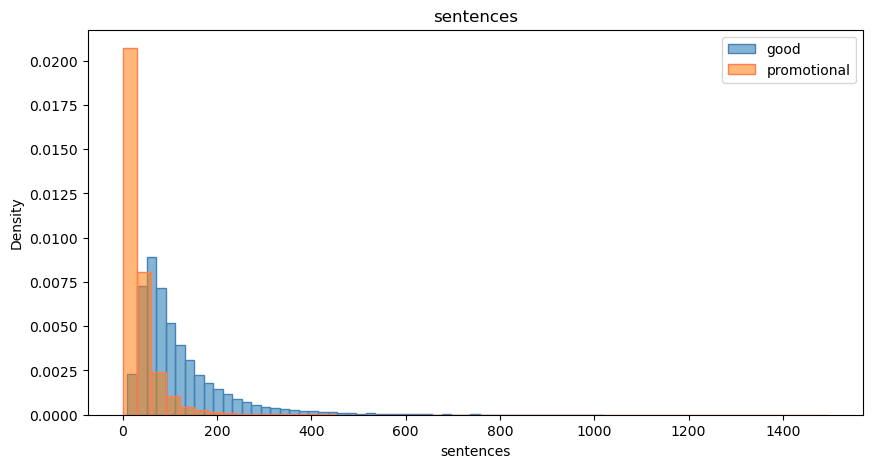

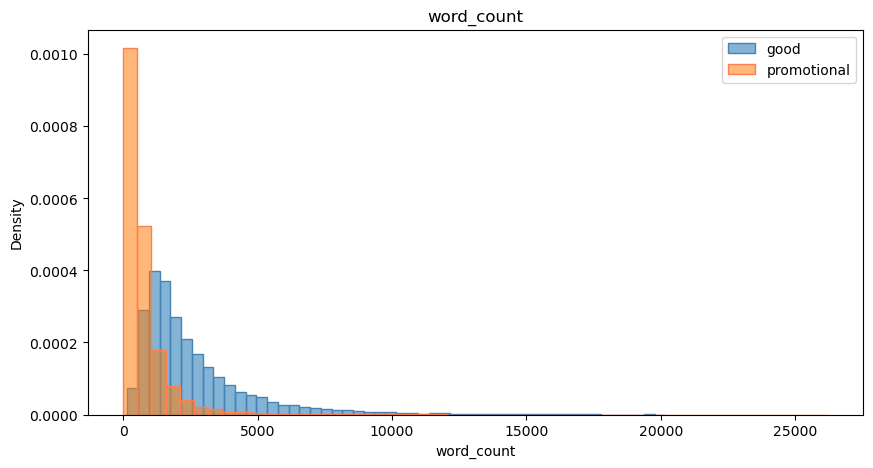

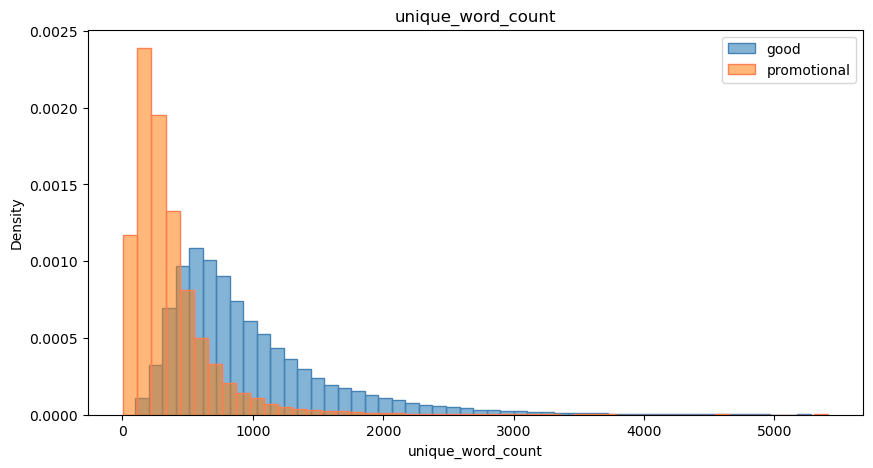

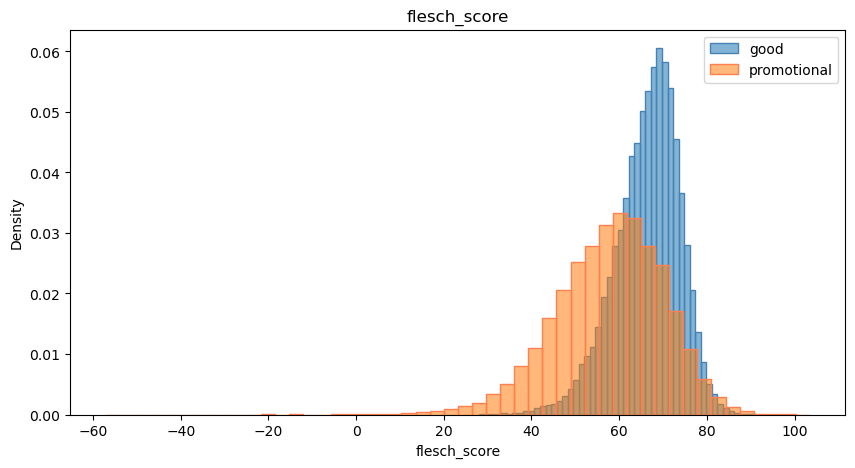

In [83]:
for col in ['sentences', 'word_count', 'unique_word_count', 'flesch_score'] :
    plt.figure(figsize=(10, 5), dpi=100)
    ax1 = sns.histplot(data=good_meta_features, x=col, label = 'good', bins = 50, stat = 'density', edgecolor='steelblue', alpha = 0.55)
    ax2 = sns.histplot(data=promotional_meta_features, x=col, label = 'promotional', bins = 50, stat = 'density', edgecolor='coral', alpha = 0.55)
    plt.title(col)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend([handles1[1],handles2[3]], [labels1[1],labels2[3]])
    plt.show()

These graphs immediately show that Good articles tend to be much longer than Promotional ones, and written at a higher reading level. This higher reading level could be related to the higher word counts, however.

Having word counts be so different on average will make classificaiton easier for our models, but perhaps subtle interpretations harder for us. Let us sample from the intersection between the word count histograms of the datasets, in order to get a subsample of the data that requires more attention to language use rather than volume.

In [85]:
# range from
print(good['word_count'].min())
# to - let us leave out the tail
print(promotional['word_count'].quantile(0.99))

154
4783.950000000001


This range has a difference which happens to be divisible by 1005, so we will use it as a sort of fine-tuning parameter in our sampling.

In [48]:
# Grabbing histogram data for the two
promos = np.array(np.histogram(promotional['word_count'], bins = 1005, range = (154, 4784)))
goods = np.array(np.histogram(good['word_count'], bins = 1005, range = (154, 4784)))

In [49]:
# Combining the above two histograms to get the intersectional metrics
sampled_word_counts = np.concatenate((goods[1][1:][promos[0] > goods[0]], promos[1][1:][goods[0] > promos[0]]))
sampled_frequency = np.concatenate((goods[0][:][promos[0] > goods[0]], promos[0][:][goods[0] > promos[0]]))
sampling_df = pd.DataFrame()
sampling_df['sampled_word_counts'] = sampled_word_counts
sampling_df['sampled_frequency'] = sampled_frequency

sampling_df = sampling_df.sort_values('sampled_word_counts').reset_index(drop = True)

In [50]:
# Taking sampled_frequency samples between min_words and max_words in sampled_word_counts
min_words = 154
promo_samples = []
good_samples = []

# There is definitely a computationally less expensive way to do this, but this is quick enough for here
for i, max_words in enumerate(sampling_df['sampled_word_counts']) :
    good_samples.append(good[good['word_count'].between(min_words, max_words)].sample(n=sampling_df['sampled_frequency'][i], random_state=2697))
    promo_samples.append(promotional[promotional['word_count'].between(min_words, max_words)].sample(n=sampling_df['sampled_frequency'][i], random_state=2697))
    min_words = max_words

good_samples = pd.concat(good_samples)
promo_samples = pd.concat(promo_samples)

In [51]:
# Sanity check
print(good_samples.shape)
print(promo_samples.shape)

(9042, 55)
(9042, 55)


And thus we have our samples, which are also balanced in class. Let us verify that we have sampled from the intersection:

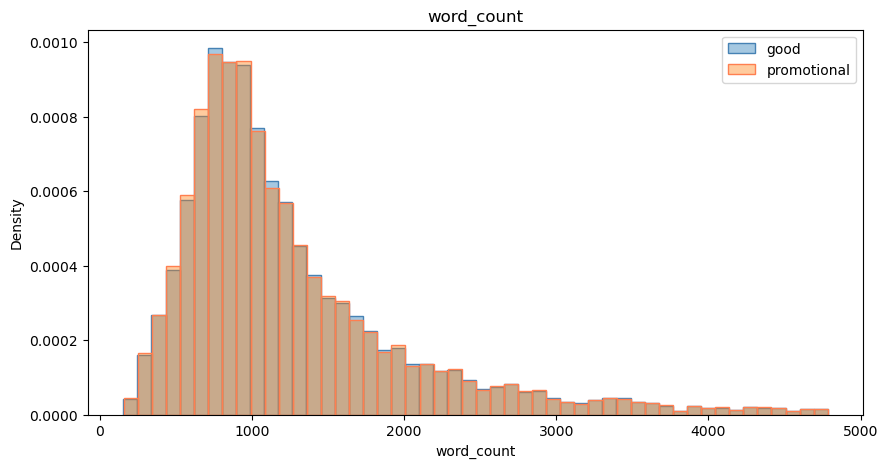

In [52]:
# Plotting Intersection
plt.figure(figsize=(10, 5), dpi=100)
ax1 = sns.histplot(data = good_samples, x = 'word_count', label = 'good', bins = 50, stat = 'density', edgecolor='steelblue', alpha = 0.4)
ax2 = sns.histplot(data = promo_samples, x = 'word_count', label = 'promotional', bins = 50, stat = 'density', edgecolor='coral', alpha = 0.4)
plt.title('word_count')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend([handles1[1],handles2[3]], [labels1[1],labels2[3]])
plt.show()

The samples look equal enough in word count distribution to continue. Let us compare metafeatures again.

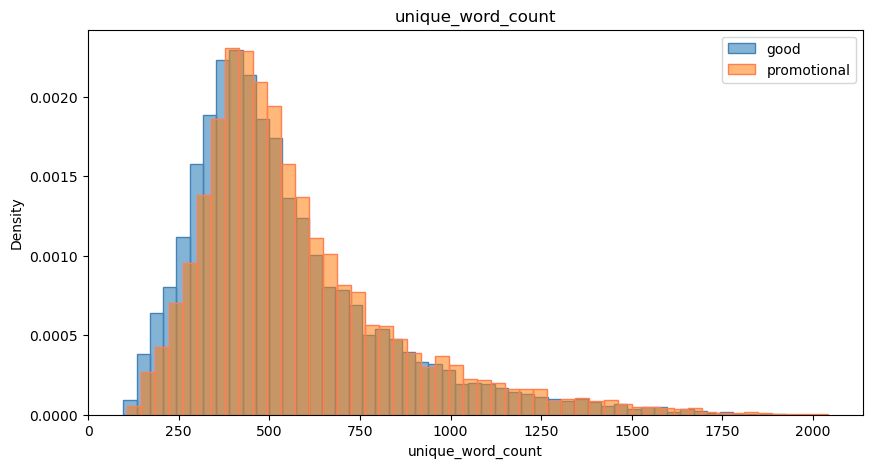

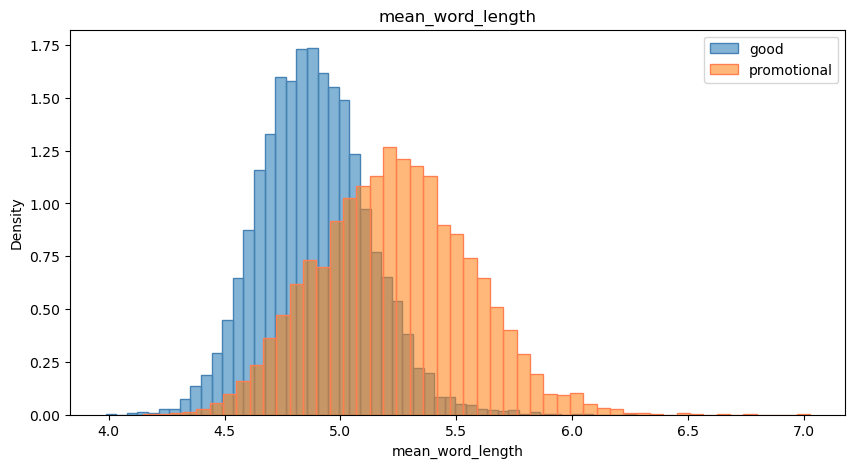

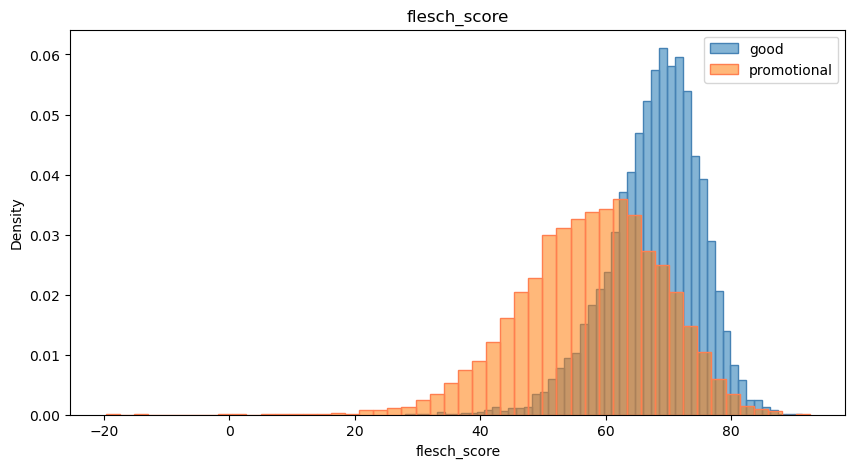

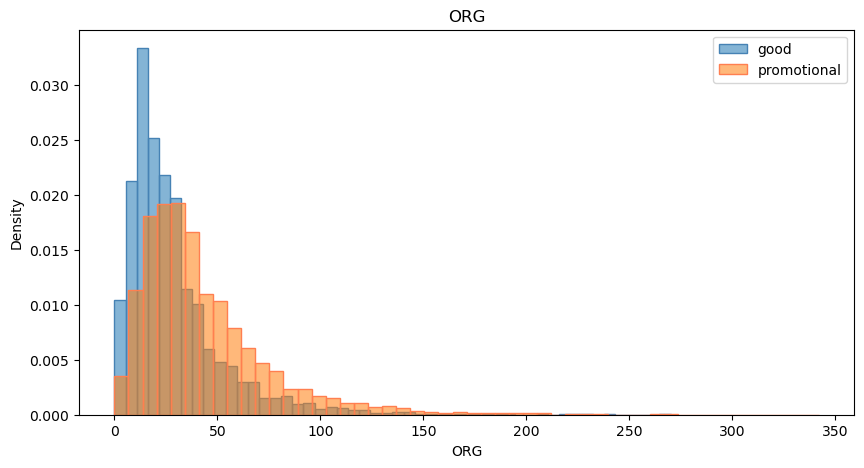

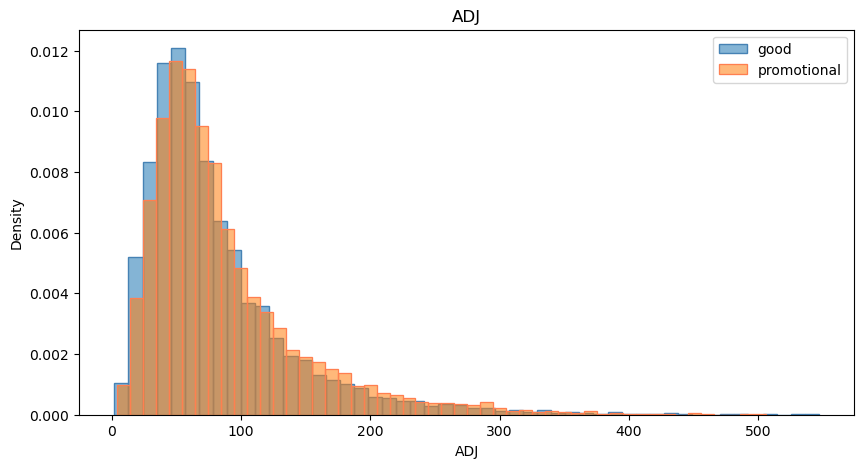

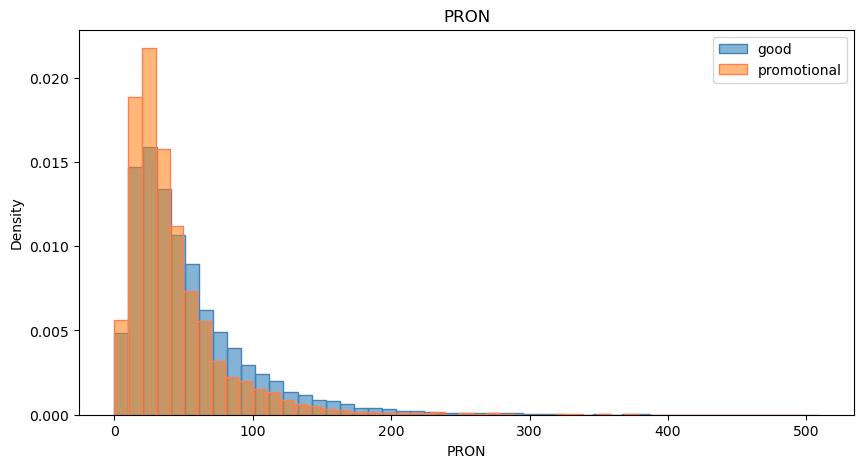

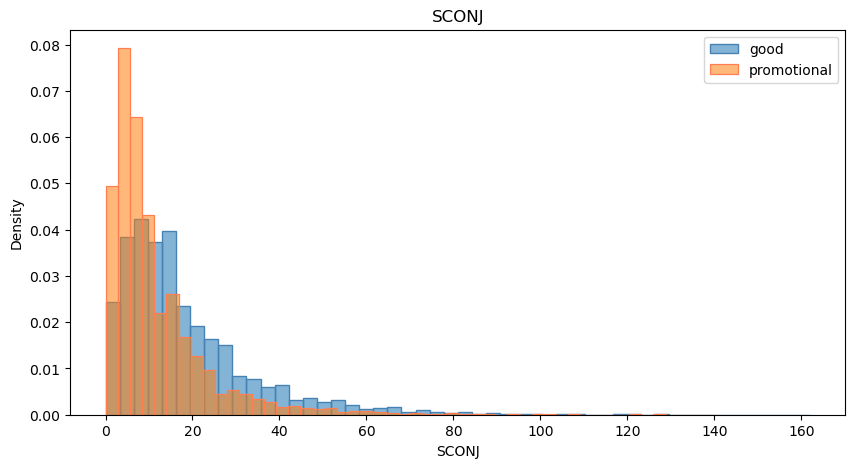

In [53]:
# Looping and plotting meta-features for subsample
for col in ['unique_word_count', 'mean_word_length', 'flesch_score', 'ORG', 'ADJ', 'PRON', 'SCONJ'] :
    plt.figure(figsize=(10, 5), dpi=100)
    ax1 = sns.histplot(data=good_samples, x=col, label = 'good', bins = 50, stat = 'density', edgecolor='steelblue', alpha = 0.55)
    ax2 = sns.histplot(data=promo_samples, x=col, label = 'promotional', bins = 50, stat = 'density', edgecolor='coral', alpha = 0.55)
    plt.title(col)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend([handles1[1],handles2[3]], [labels1[1],labels2[3]])
    plt.show()

Promotional articles here tend to contain slightly more unique words, though they tend to be significantly longer. Good articles tend to require a higher reading ability. Some other metafeatures are somehow quite different between the two datasets as well.

## Analysis via modeling

Let us use machine learning algorithms to try and understand the texts a little more. We shall first generate a TF-IDF representation of the corpus, and then run that through a Logistic Regression model in order to investigate its coefficients.

In [54]:
# Helper code to generate TF-IDF Pipelines
def generate_pipeline(corpus):
    """Generate and fit a TF-IDF Pipeline to a corpus"""
    pipe = Pipeline([('count', CountVectorizer(stop_words="english",
                                               tokenizer = lambda x: [PorterStemmer().stem(w.lower()) for w in x.split(' ')],
                                               ngram_range=(1,1))),
                     ('tfid', TfidfTransformer())])

    pipe = pipe.fit(corpus)
    return pipe

In [55]:
# Creating an omnibus corpus
all_articles = pd.concat([good[['text', 'is_not_promo']], promotional[['text', 'is_not_promo']]]).reset_index(drop = True)

# Have to make X a list to appease the Pipeline
X = list(all_articles['text'])
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify = y)

In [22]:
# Generating Pipeline - can take a while
text_pipeline = generate_pipeline(X_train)

In [ ]:
# Traansforming and saving feature data
X_train_tfidf = text_pipeline.transform(X_train)
X_test_tfidf = text_pipeline.transform(X_test)

sparse.save_npz("X_train_tfidf.npz", X_train_tfidf)
sparse.save_npz("X_test_tfidf.npz", X_test_tfidf)

In [23]:
# Read data for convenience
X_train_tfidf = sparse.load_npz("X_train_tfidf.npz")
X_test_tfidf = sparse.load_npz("X_test_tfidf.npz")

In [24]:
# Sanity Check
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(42540, 958297)
(10636, 958297)


We have nearly a million features here. Typically, we should have less features than datapoints in our models, but we can do that kind of processing later for when we are modeling for performance rather than analysis.

In [25]:
# Also Sanity Check
print(len(text_pipeline.get_feature_names_out()))

958297


In [26]:
# Instantiating Logistic regression model
baseline_LR_model_tfidf = LogisticRegression(n_jobs=-1)
baseline_LR_model_tfidf.fit(X_train_tfidf, y_train)

# Training and test score
print(f"Train score: {baseline_LR_model_tfidf.score(X_train_tfidf, y_train)}")
print(f"Test score: {baseline_LR_model_tfidf.score(X_test_tfidf, y_test)}")
print('\n')

Train score: 0.9644569816643159
Test score: 0.9429296728093268




Our Logistic Regression model is quite accurate. Bear in mind that there is a class imbalance, so judging performance here is better done with a classification report. Still though, the testing performance is quite high, indicating that word choice could be quite an important distinction between the classes.

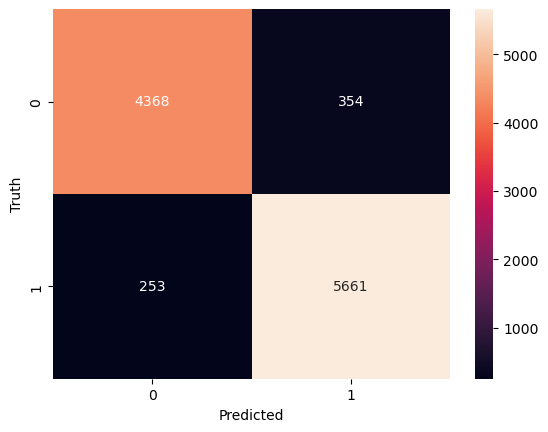

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4722
           1       0.94      0.96      0.95      5914

    accuracy                           0.94     10636
   macro avg       0.94      0.94      0.94     10636
weighted avg       0.94      0.94      0.94     10636



In [27]:
# Displaying Confusion Matrix and Classification Report
y_pred = baseline_LR_model_tfidf.predict(X_test_tfidf)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print(classification_report(y_test, y_pred))

Using the whole dataset, the basic model scores a testing accuracy of 94%. There are about 25% more Good articles than Promotional however, so perhaps it would be wiser to look at the recall scores, which indicate how well the model predicts over each class of data. The model catches 93% of Promotional articles, and 96% of Good articles, perhaps suggesting that Good articles tend to be more consistent in word choice.

The dictionary below takes a long time to create, helps with explaining the coefficients later on.

In [ ]:
# Creating Dictionary of stemmed words
stemmer = PorterStemmer()

Stemmer_Dictionary = defaultdict(set)
for word in lexicon:
    Stemmer_Dictionary[stemmer.stem(word)].add(word)

# SavingDictionary
with open('file.pkl', 'wb') as f:
    pickle.dump(Stemmer_Dictionary, f)

In [32]:
# Loading Dictionary
with open('file.pkl', 'rb') as f:
    Stemmer_Dictionary = pickle.load(f)

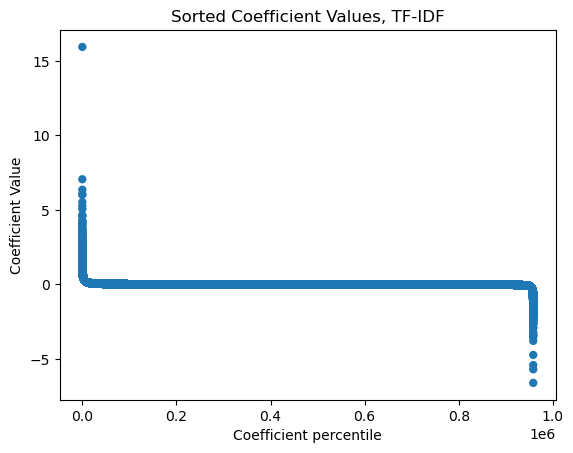

In [106]:
# Creating a coefficients DataFrame
coefficients = pd.DataFrame()
coefficients['Feature'] = text_pipeline.get_feature_names_out()
coefficients['Coefficients'] = baseline_LR_model_tfidf.coef_[0]
coefficients = coefficients.sort_values('Coefficients', ascending = False).reset_index(drop = True)
coefficients['Examples'] = coefficients['Feature'].apply(lambda txt: Stemmer_Dictionary[txt])

# For some reason, the x-values here come out in an unconventional format
sns.scatterplot(x = range(coefficients.shape[0]), y = coefficients['Coefficients'], edgecolor='None')
plt.title('Sorted Coefficient Values, TF-IDF')
plt.xlabel('Coefficient percentile')
plt.ylabel('Coefficient Value')
plt.show()

Above, we can see that the vast majority of TF-IDF features contribute next to nothing, compared to the values at the tail ends. This shows that a small group of terms here will be most indicative of class, which will be useful for when we want to reduce dimensionality later.

In [34]:
# Assigning top and bottom 100 coefficients
top_100 = coefficients[:100]
bottom_100 = coefficients[-100:]

Looking at the model’s coefficients, we can see that the term ‘wa’, which stems from words like ‘was’, is the most predictive of an article being Good. Perhaps this indicates that Good articles may generally be more historical in nature. Other terms of this nature include 'describe', 'however', 'during', 'critic', 'praise', and other such formal words, suggesting that Good articles tend to be written in this formal style – or rather, that Promotional articles tend not to be written this way. 

In [35]:
top_100

,Feature,Coefficients,Examples
0,wa,15.931511,"{Was, was, WA, WAS, wa, Wa, wAS}"
1,describ,7.052973,"{describable, describ, described, Describing, ..."
2,.,6.349267,{.}
3,speci,6.034662,"{specie, species, Specie, Species}"
4,said,6.016233,"{Saide, SAIDE, Said, SAIDS, SAID, said}"
5,dure,5.522673,"{Dure, durings, Duree, Dures, during, dure, Du..."
6,note,5.275416,"{NOTES, note, notes, Noted, NOTE, Noting, note..."
7,"however,",5.057274,"{however,, However,}"
8,rout,4.637010,"{routed, Routed, routing, ROUTES, ROUTE, route..."
9,critic,4.622304,"{Criticisms, Critic, critics, critical, critic..."


Looking at the other end, in terms of the predictive power of Promotional articles, we see present-tense terms such as ‘has’, ‘current’, and ‘new’, which indicates that Promotional articles are much more likely to be written about current events. From a high level, it makes sense that someone trying to influence public opinion would be more concerned with writing about present conditions than past ones – and those who would want to spin history would likely be stopped by Wikipedia moderators. Otherwise, on this end of the predictive spectrum we see terms such as 'business', 'technology', 'company', 'born', 'director', 'manager', and 'institute', which is what one would expect to see in articles promoting products, organizations, or businesspeople. 

In [36]:
bottom_100

,Feature,Coefficients,Examples
958197,partnership,-1.442154,"{Partnership, partnerships, partnership, PARTN..."
958198,"2018,",-1.462652,"{2018,}"
958199,hit,-1.486205,"{Hitting, hitting, hit, HIT, Hits, HiT, Hit, h..."
958200,ceo,-1.494834,"{CEO, CeO, CEOs, CEOS, Ceo, ceo, Ceos}"
958201,creativ,-1.504878,"{creative, creativeness, creatively, creativ, ..."
958202,integr,-1.515394,"{integration, integrator, Integrator, Integral..."
958203,hospit,-1.517557,"{hospitalize, hospitality, Hospitals, hospital..."
958204,client,-1.518349,"{Client, ClienT, clientes, clients, Clients, c..."
958205,got,-1.530526,"{GoT, Gots, GOT, GOTS, got, Got}"
958206,thi,-1.541795,"{THIS, Thy, Thies, Thi, THY, Thys, This, THiS,..."


Let us now do the same with meta-features:

In [67]:
# Saving meta feature data
good_meta_features.drop(columns = ['Unique Entities']).to_csv('good_meta_features.csv')
promotional_meta_features.drop(columns = ['Unique Entities']).to_csv('promotional_meta_features.csv')

In [68]:
# Loading meta feature data
good_meta_features = pd.read_csv('good_meta_features.csv').drop(columns = ['Unnamed: 0'])
promotional_meta_features = pd.read_csv('promotional_meta_features.csv').drop(columns = ['Unnamed: 0'])

In [69]:
# Sanity Check
good_meta_features['is_not_promo'] = 1
promotional_meta_features['is_not_promo'] = 0

In [70]:
promotional_meta_features

,char_count,sentences,word_count,unique_word_count,stop_word_count,mean_word_length,flesch_score,fleschkincaid_score,gunningfog_score,smog_score,dalechall_score,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART,Num Entities,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,is_not_promo
0,3439,29,617,353,253,4.575365,74.435854,8.145405,10.954303,9.668497,9.463874,6,14,0,0,3,0,0,0,0,9,0,11,0,15,0,0,1,2,61,37,72,14,32,20,64,0,117,27,19,32,96,69,15,0,78,0,0
1,1547,10,255,168,90,5.070588,63.507794,10.736176,13.964706,11.979248,9.483496,5,10,0,0,4,0,0,2,0,0,0,3,0,2,0,0,0,0,26,20,27,6,12,10,21,0,49,17,7,8,48,22,3,0,29,0,0
2,5550,43,869,499,308,5.387802,54.479143,10.926040,13.679430,12.613115,10.720321,14,19,0,0,14,0,3,0,1,0,3,35,0,7,1,0,0,1,98,45,109,21,28,33,66,0,199,35,22,30,170,97,9,0,104,4,0
3,11461,73,1796,819,667,5.381960,53.418944,11.730978,14.994613,13.433180,11.548259,36,21,1,3,19,2,1,0,2,10,3,47,0,32,2,0,0,0,179,114,226,41,94,60,172,0,420,38,59,53,317,155,22,0,200,0,0
4,1300,9,195,140,65,5.671795,55.557179,10.892821,14.615385,13.383793,11.189115,5,2,0,0,5,0,0,0,0,1,1,8,0,7,1,0,0,0,30,12,23,2,7,12,18,0,42,7,4,4,44,37,1,0,21,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23601,895,6,134,114,36,5.686567,56.778409,9.438939,11.448485,11.208143,13.665733,0,2,0,0,2,0,0,0,0,1,0,4,0,15,0,0,0,1,25,8,15,0,4,4,11,0,27,1,1,1,55,20,0,0,4,1,0
23602,2678,47,389,217,90,5.886889,59.774313,6.712566,10.212862,9.694422,12.219675,6,12,0,0,5,0,0,0,0,0,0,23,0,9,1,0,0,0,56,21,39,4,8,15,19,0,99,26,3,8,107,72,0,0,34,3,0
23603,1306,11,189,130,56,5.915344,36.757359,12.400856,14.703415,13.606402,13.010305,0,2,0,0,0,0,0,1,0,0,0,8,0,1,0,0,0,0,12,24,24,4,5,12,12,0,69,2,1,1,19,26,1,0,15,0,0
23604,4643,36,762,365,329,5.094488,69.457081,7.510076,10.178723,10.174177,9.132893,8,7,0,0,6,2,0,1,0,6,1,14,0,3,0,0,1,1,50,69,91,36,38,33,78,0,174,16,16,43,64,81,14,0,89,1,0


In [71]:
good_meta_features

,char_count,sentences,word_count,unique_word_count,stop_word_count,mean_word_length,flesch_score,fleschkincaid_score,gunningfog_score,smog_score,dalechall_score,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART,Num Entities,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,is_not_promo
0,3466,30,590,269,243,4.876271,69.938563,8.307241,11.526437,10.864195,10.503071,7,1,0,0,7,0,0,1,0,4,5,5,0,8,0,3,0,0,41,71,72,19,27,22,85,0,125,12,3,19,63,79,5,0,57,0,1
1,3230,29,541,271,239,4.972274,67.112857,8.515764,11.664538,11.138194,9.831474,2,10,0,0,11,0,0,2,0,7,0,12,0,11,0,3,0,0,58,43,71,25,35,24,70,0,90,17,3,23,82,58,11,0,46,0,1
2,22691,178,3793,1445,1486,4.982600,70.140028,7.331435,9.983594,10.043696,9.644429,38,16,3,1,23,1,0,4,0,12,13,81,0,64,4,0,2,7,269,277,452,78,126,145,482,1,927,115,130,172,391,387,50,0,474,9,1
3,5620,55,1021,482,463,4.505387,85.788270,4.108162,6.658197,7.562547,7.746048,15,7,0,0,6,0,0,2,0,1,1,19,0,10,0,1,0,3,65,55,127,34,40,38,114,1,202,36,16,91,107,117,19,0,128,0,1
4,9303,75,1565,725,620,4.945048,80.265285,4.348581,7.173717,8.250128,9.621698,20,15,0,0,19,0,0,1,0,9,6,37,3,68,1,0,3,1,183,96,200,44,52,68,182,1,283,69,42,71,264,196,20,0,171,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29565,32625,186,5104,1778,2019,5.392241,47.528310,13.067660,17.091040,15.053755,11.179973,52,65,19,0,100,0,1,8,0,322,6,85,4,77,0,0,0,0,739,637,810,149,164,165,569,0,980,128,93,148,711,448,90,0,477,1,1
29566,6668,73,1081,501,412,5.169288,66.967410,7.517566,10.533401,10.613051,9.598724,15,8,0,0,20,0,0,0,0,3,10,17,0,12,0,5,1,1,92,114,138,35,55,42,125,1,274,33,14,26,105,130,9,0,104,2,1
29567,9625,64,1583,637,668,5.080859,59.847574,11.013802,14.506934,12.815533,9.907198,33,3,0,0,8,0,0,3,0,6,5,10,0,26,1,7,0,0,102,150,210,80,75,58,198,5,382,59,22,62,120,156,7,0,144,0,1
29568,15576,125,2588,1074,1024,5.018934,64.830694,9.423634,12.324779,11.338459,10.163997,22,57,8,3,36,1,3,1,0,26,3,73,8,32,3,5,2,1,284,150,398,66,107,88,265,0,586,100,43,84,383,262,24,0,288,0,1


In [72]:
# Meta Feature Modeling
all_articles = pd.concat([good_meta_features, promotional_meta_features]).reset_index(drop = True)

X = all_articles.drop(columns=['is_not_promo'])
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify = y)

# Instantiating Logistic regression model
baseline_LR_model_meta_features = LogisticRegression(n_jobs=-1)
baseline_LR_model_meta_features.fit(X_train, y_train)

# Training and test score
print(f"Train score: {baseline_LR_model_meta_features.score(X_train, y_train)}")
print(f"Test score: {baseline_LR_model_meta_features.score(X_test, y_test)}")

Train score: 0.8924071462153268
Test score: 0.8925347875141031


This accuracy is notably lower than that of the TF-IDF model, though still pretty good considering it uses a few orders of magnitude less data. A decent level of performance was expected however, as a result of the large differences in basic attributes such as word count.

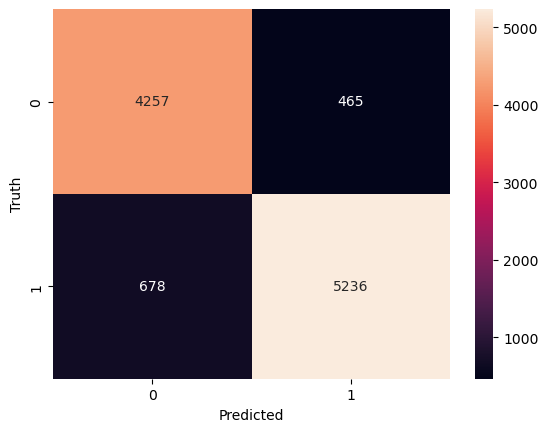

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4722
           1       0.92      0.89      0.90      5914

    accuracy                           0.89     10636
   macro avg       0.89      0.89      0.89     10636
weighted avg       0.89      0.89      0.89     10636



In [73]:
# Displaying Confusion Matrix and Classification Report
y_pred = baseline_LR_model_meta_features.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print(classification_report(y_test, y_pred))

The recalls here are quite similar.

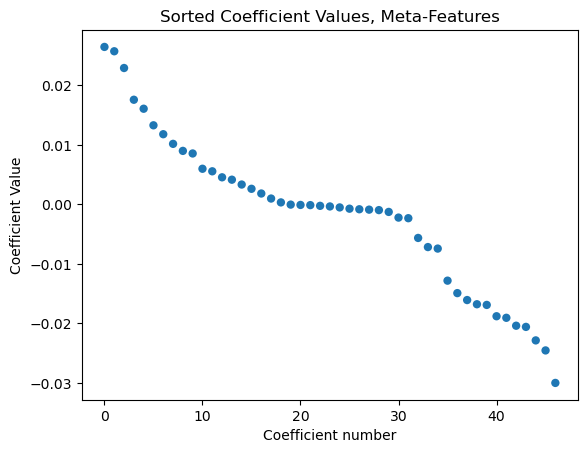

In [103]:
# Creating a coefficients DataFrame
coefficients = pd.DataFrame()
coefficients['Feature'] = good_meta_features.columns[:-1]
coefficients['Coefficients'] = baseline_LR_model_meta_features.coef_[0]
coefficients['Explanations'] = coefficients['Feature'].apply(lambda txt: GLOSSARY[txt] if txt in GLOSSARY else txt)
coefficients = coefficients.sort_values('Coefficients', ascending = False).reset_index(drop = True)

# Plotting coefficients
sns.scatterplot(x = range(coefficients.shape[0]), y = coefficients['Coefficients'], edgecolor='None')
plt.title('Sorted Coefficient Values, Meta-Features')
plt.xlabel('Coefficient number')
plt.ylabel('Coefficient Value')
plt.show()

The coefficients here are much closer than in the previous model.

This model’s coefficients suggest that Good articles tend to include more quantitative information and more references to people – the latter point being especially interesting, since one might otherwise expect Promotional articles to talk more about individuals. This may be a result of Good articles overall being longer, and therefore prone to making more references to people. On the other end, we do see that more nouns, and references to organizations makes an article more likely to be Promotional.

Somewhat surprisingly, readability scores here have negative coefficients. This makes sense for some of them, but the Flesch score in particular is supposed to increase with difficulty and favor Good articles, which makes its placement unexpected.

In [75]:
# Displaying all meta-feature coefficients
coefficients

,Feature,Coefficients,Explanations
0,ADP,0.026444,adposition
1,DET,0.025715,determiner
2,SCONJ,0.022902,subordinating conjunction
3,PERSON,0.017569,"People, including fictional"
4,NUM,0.016061,numeral
5,QUANTITY,0.013277,"Measurements, as of weight or distance"
6,VERB,0.011780,verb
7,sentences,0.010160,sentences
8,word_count,0.008978,word_count
9,FAC,0.008544,"Buildings, airports, highways, bridges, etc."


Let us prepare to test how BERT handles this data:

In [76]:
# Downloading BERT preprocessor and encoder
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=False, name='BERT_encoder')

BERT is a pre-trained neural network architecture that can take in text inputs up to 126 tokens long and generates a 768 feature long vector representation of the text. Essentially, it has learned to encode not just the semantics of words, but the semantics of words in context, or entire sentences. If BERT encodings can be used to distinguish between the classes, it is reason to believe that sentence content or style plays a role. 

BERT processes 126 tokens at a time, and then 2 additional ones that denote text start and end. We shall run BERT over the beginning, middle and ending 126 tokens of each text, both together and separately.

BERT layers are typically constructed within a neural network model, but for our purposes it's more convenient to simply preprocess all the text and put it into a simple feed forward neural network. In practice, a trainable version of BERT is supposedly downloaded and then fine tuned, but the tools required to do that have been causing trouble on my machine, so I opted to use this simplified method instead. I tried using GCP, but this presented me with some other problems, their standard GPUs didn't run much faster than my own, and their powerful GPUs weren't available, so I opted to just run my simpler models locally.

First we must split the text, and then run the embedding algorithm over each section.

In [77]:
# Combining data and splitting text into beginning, middle, and end parts.
all_articles = pd.concat([good[['text', 'is_not_promo']], promotional[['text', 'is_not_promo']]]).reset_index(drop = True)

all_articles["text_ls"] = all_articles["text"].apply(lambda txt: txt.split(' '))
all_articles["beg"] = all_articles["text_ls"].apply(lambda txt: ' '.join(txt[:126]))
all_articles["mid"] = all_articles["text_ls"].apply(lambda txt: ' '.join(txt[round(len(txt)/2)-63:round(len(txt)/2)+64]))
all_articles["end"] = all_articles["text_ls"].apply(lambda txt: ' '.join(txt[-126:]))
all_articles

,text,is_not_promo,text_ls,beg,mid,end
0,Nycticebus linglom is a fossil strepsirrhine p...,1,"[Nycticebus, linglom, is, a, fossil, strepsirr...",Nycticebus linglom is a fossil strepsirrhine p...,and Ginsburg claim that it is the smallest kno...,", the angwantibos Arctocebus , and the pygmy s..."
1,Oryzomys pliocaenicus is a fossil rodent from ...,1,"[Oryzomys, pliocaenicus, is, a, fossil, rodent...",Oryzomys pliocaenicus is a fossil rodent from ...,"in it. Much of the back of the jaw is missing,...",O. pliocaenicus in 1952 he no longer thought t...
2,.hack dt hk is a series of single player actio...,1,"[.hack, dt, hk, is, a, series, of, single, pla...",.hack dt hk is a series of single player actio...,and surprising the player and creating a disti...,establish ad hoc chat rooms separate from the ...
3,The You Drive Me Crazy Tour was the second con...,1,"[The, You, Drive, Me, Crazy, Tour, was, the, s...",The You Drive Me Crazy Tour was the second con...,teacher voice started calling their names. Aft...,we have a signal where I'm dying and they'll h...
4,0 8 4 is the second episode of the first seaso...,1,"[0, 8, 4, is, the, second, episode, of, the, f...",0 8 4 is the second episode of the first seaso...,"May, Grant Ward, Skye, Leo Fitz, and Jemma Sim...","praised the scale of the episode, describing i..."
...,...,...,...,...,...,...
53171,ZURICH.MINDS is a non profit foundation set up...,0,"[ZURICH.MINDS, is, a, non, profit, foundation,...",ZURICH.MINDS is a non profit foundation set up...,profit foundation set up in June 2008 by Rolf ...,in June 2008 by Rolf Dobelli. The goal of the ...
53172,"zvelo, Inc. or simply zvelo is a privately hel...",0,"[zvelo,, Inc., or, simply, zvelo, is, a, priva...","zvelo, Inc. or simply zvelo is a privately hel...","market, to be integrated into web filtering so...","the network security, endpoint security, ad ne..."
53173,Zygote Media Group is a 3D human anatomy conte...,0,"[Zygote, Media, Group, is, a, 3D, human, anato...",Zygote Media Group is a 3D human anatomy conte...,since specialized in enhanced visualization of...,specialized services in the development of lif...
53174,Zylom is a distributor of casual games for PC ...,0,"[Zylom, is, a, distributor, of, casual, games,...",Zylom is a distributor of casual games for PC ...,fooled that they are about to actually downloa...,"studio was closed, but Zylom still continues t..."


In [78]:
def get_embeddings_of_series(series):
    """A function to convert text to BERT embeddings"""
    embeddings = []
    
    # Done in sets of 22 - I found that this was a reasonably time efficient set number
    groups = math.floor(len(series)/22)
    for i in range(groups) :
        embeddings.append(bert_encoder(bert_preprocess(series[i*22:(i + 1)*22]))['pooled_output'].numpy())
    remainder = len(series)%22
    if remainder > 0 :
        embeddings.append(bert_encoder(bert_preprocess(series[groups*22 : groups*22 + remainder]))['pooled_output'].numpy())
    
    return pd.DataFrame(np.concatenate(embeddings))

In [ ]:
# Embedding text
three_part_embeddings = pd.concat([get_embeddings_of_series(all_articles['beg']), get_embeddings_of_series(all_articles["mid"]), get_embeddings_of_series(all_articles["end"])], axis=1)
three_part_embeddings.columns = range(768*3)
three_part_embeddings.to_csv('three_part_embeddings.csv')
three_part_embeddings.head()

In [79]:
# Reading for convenience
three_part_embeddings  = pd.read_csv('three_part_embeddings.csv').drop(columns = ['Unnamed: 0'])
three_part_embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2183,2184,2185,2186,2187,2188,2189,2190,2191,2192,2193,2194,2195,2196,2197,2198,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215,2216,2217,2218,2219,2220,2221,2222,2223,2224,2225,2226,2227,2228,2229,2230,2231,2232,2233,2234,2235,2236,2237,2238,2239,2240,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256,2257,2258,2259,2260,2261,2262,2263,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,-0.368387,0.494306,0.956846,-0.389323,-0.620724,0.596148,-0.728816,-0.488505,0.806263,-0.963157,0.156740,-0.435054,0.811503,-0.945074,0.024012,0.198205,0.713380,0.431988,-0.346526,0.913566,-0.741953,-0.996011,0.726962,-0.405706,-0.636852,-0.908528,0.066874,0.409233,0.646417,0.227850,0.577931,-0.655732,-0.816992,0.603887,0.943369,-0.461682,-0.671760,-0.228653,0.728924,0.530759,-0.316358,-0.480756,0.957590,-0.858792,-0.725939,0.519613,0.999969,-0.534788,-0.382184,-0.911149,-0.897975,-0.878188,-0.588346,-0.709130,-0.527352,0.475900,-0.777903,-0.616443,0.391350,0.629379,0.313547,-0.814031,0.747840,-0.227190,-0.816744,-0.959939,0.687916,0.671429,0.757189,-0.760735,-0.259482,-0.640408,0.550917,-0.043382,-0.953512,-0.446823,-0.927949,-1.000000,0.536055,-0.837557,-0.877859,-0.939057,0.865484,0.932299,-0.980414,0.999998,-0.196779,0.668394,-0.846345,-0.647856,-0.333120,0.660645,-0.964067,0.894397,0.862890,0.625708,0.442124,0.608341,0.717382,0.635933,-0.701829,0.647606,0.637817,0.284868,-0.475881,0.472618,0.868509,-0.605040,-0.891313,-0.423572,0.819380,0.544436,-0.694767,-0.790025,-0.312857,0.424239,-0.859128,-0.926482,-0.849392,-0.075238,0.745122,0.563977,0.312974,0.909366,-0.517866,0.833686,0.869520,1.000000,0.326558,0.464505,0.638675,0.737878,-0.774679,-0.721301,-0.523455,0.691360,-0.607128,0.850814,0.776664,0.582255,0.898316,0.561456,-0.695666,0.595289,-0.671514,-0.834288,0.373127,-0.426950,0.580411,-0.550687,0.759933,0.327345,0.897418,-0.556902,0.387268,0.420229,0.846867,0.971067,0.930657,0.686235,0.640830,0.168726,-0.642049,-0.555538,0.792422,-0.555799,-0.985539,-0.500044,0.137770,0.700114,-0.699859,0.391178,0.956647,-0.807666,0.474009,-0.386464,0.814312,-0.132462,-0.592619,-0.852393,0.432830,0.214447,-0.647135,0.822896,0.757408,-0.648209,0.622941,-0.519827,-0.500350,-0.882802,-0.433747,0.502605,-0.754803,0.775761,0.176377,0.7

The embeddings above are unfortunately rather uninterpretable to the typical human.

In [80]:
def plot_NN(model, X_test, y_test):
    """Helper function to display Neural Network Performance"""
    
    # Creating binary predictions
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)

    # Plotting confusion matrix and classification report
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    print('\n')
    print(classification_report(y_test, y_pred))

# This function doesn't actually do anything BERT specific, I just left the name
# after realizing I could simply preprocess the embeddings if I wasn't going to
# train any BERT parameters.
def BERT_encoded_model(X_train, X_test, y_train, y_test, layers = 3, epochs = 5, verbose = 0):
    """Create and train a Neural Network"""
    
    # Scale Data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Input layer
    embeddings_input = tf.keras.layers.Input(shape = (X_train.shape[1],), name='Embeddings')

    # Hidden Layers
    for i in range(layers):
        layer = tf.keras.layers.Dropout(0.1)(embeddings_input)
        layer = tf.keras.layers.Dense(X_train.shape[1], activation='relu')(layer)

    layer = tf.keras.layers.Dropout(0.1)(layer)
    layer = tf.keras.layers.Dense(1, activation='sigmoid')(layer)

    # Construct Model
    BERT_model = tf.keras.Model(inputs=[embeddings_input], outputs = [layer])

    BERT_model.compile('adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

    # Fit Model
    BERT_model.fit(X_train, y_train, epochs=epochs, verbose=verbose)
    
    # Evaluate Model
    print('Training Accuracy')
    BERT_model.evaluate(X_train, y_train)
    print('Testing Accuracy')
    BERT_model.evaluate(X_test, y_test)
    print('\n')
    
    # Plot Model
    plot_NN(BERT_model, X_test, y_test)
    
    return BERT_model

In [93]:
# Sanity Check
print(three_part_embeddings.shape)
print(all_articles.shape)

(53176, 2304)
(53176, 6)


Training Accuracy
1330/1330 [==============================] - 4s 3ms/step - loss: 0.1942 - accuracy: 0.9388
Testing Accuracy
333/333 [==============================] - 1s 3ms/step - loss: 0.2308 - accuracy: 0.9291




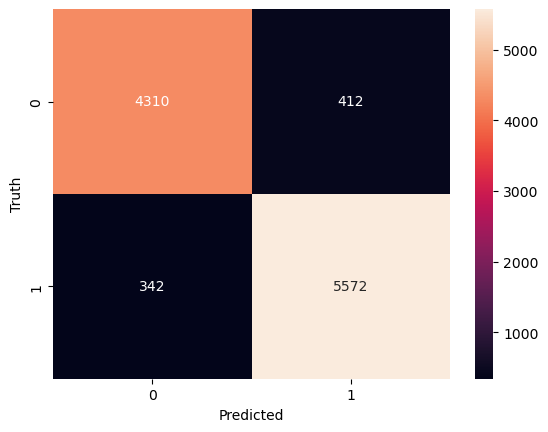



              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4722
           1       0.93      0.94      0.94      5914

    accuracy                           0.93     10636
   macro avg       0.93      0.93      0.93     10636
weighted avg       0.93      0.93      0.93     10636



In [94]:
# Test NN using all 3 text sections

X = three_part_embeddings
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify=y)

BERT_model = BERT_encoded_model(X_train, X_test, y_train, y_test, layers = 3, epochs = 5, verbose = 0)

The majority of texts are larger than 126x3 words long, which probably lends to the accuracy score here. We can see that BERT encodings can be quite predictive of class, even if it uses a subsample of the whole text.

Training Accuracy
1330/1330 [==============================] - 4s 3ms/step - loss: 0.1933 - accuracy: 0.9226
Testing Accuracy
333/333 [==============================] - 1s 3ms/step - loss: 0.2178 - accuracy: 0.9165




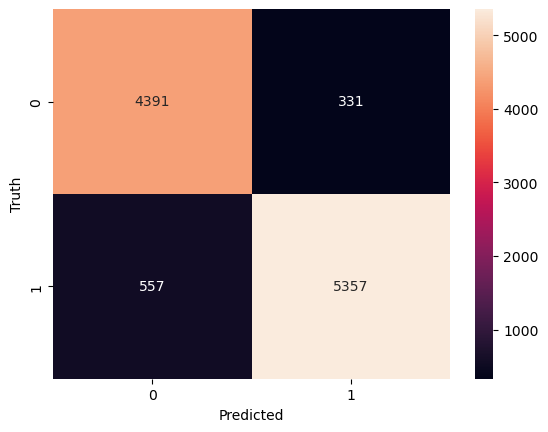



              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4722
           1       0.94      0.91      0.92      5914

    accuracy                           0.92     10636
   macro avg       0.91      0.92      0.92     10636
weighted avg       0.92      0.92      0.92     10636



In [95]:
# Test NN using only beginnings

X = three_part_embeddings[[str(i) for i in range(768)]]
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify=y)

BERT_model = BERT_encoded_model(X_train, X_test, y_train, y_test, layers = 3, epochs = 15, verbose = 0)

We see here that beginnings can already rather consistently reveal class.

Training Accuracy
1330/1330 [==============================] - 3s 2ms/step - loss: 0.1744 - accuracy: 0.9303
Testing Accuracy
333/333 [==============================] - 1s 3ms/step - loss: 0.2053 - accuracy: 0.9195




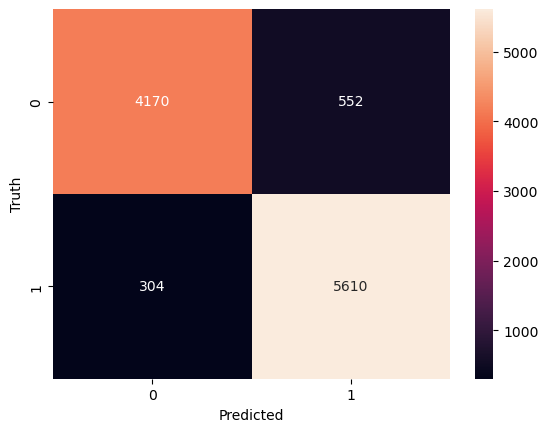



              precision    recall  f1-score   support

           0       0.93      0.88      0.91      4722
           1       0.91      0.95      0.93      5914

    accuracy                           0.92     10636
   macro avg       0.92      0.92      0.92     10636
weighted avg       0.92      0.92      0.92     10636



In [96]:
# Test NN using only middles

X = three_part_embeddings[[str(i) for i in range(768,768*2)]]
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify=y)

BERT_model = BERT_encoded_model(X_train, X_test, y_train, y_test, layers = 3, epochs = 15, verbose = 0)

The difference between the recall scores here are of note, it seems that it's much easier to identify Good articles from middle sections than Promotional ones.

Training Accuracy
1330/1330 [==============================] - 4s 3ms/step - loss: 0.2006 - accuracy: 0.9201
Testing Accuracy
333/333 [==============================] - 1s 3ms/step - loss: 0.2314 - accuracy: 0.9069




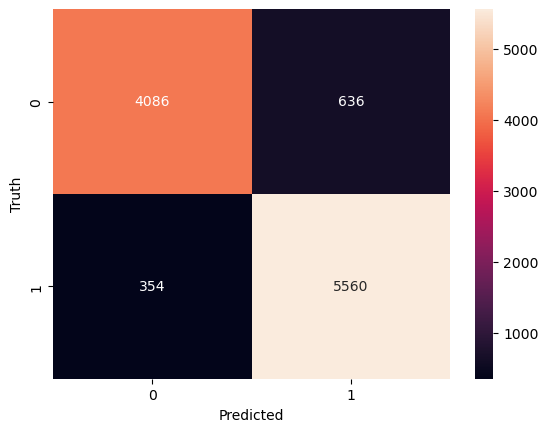



              precision    recall  f1-score   support

           0       0.92      0.87      0.89      4722
           1       0.90      0.94      0.92      5914

    accuracy                           0.91     10636
   macro avg       0.91      0.90      0.91     10636
weighted avg       0.91      0.91      0.91     10636



In [97]:
# Test NN using only endings

X = three_part_embeddings[[str(i) for i in range(768*2,768*3)]]
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify=y)

BERT_model = BERT_encoded_model(X_train, X_test, y_train, y_test, layers = 3, epochs = 15, verbose = 0)

We see a similar pattern to the above for endings.

It seems that BERT encodings of small samples of texts are already predictive enough of a text's class. This suggests that texts tend to be written on the whole in a consistent style, or rather Good texts are. This is of note, because although many Wikipedia articles tend to have multiple authors, it seems that they have learned to be consistent in their Good texts. Conversely, this suggests to me that promotional articles tend to vary much more widely in terms of writing style, which makes sense given the example promotional articles shown earlier.

# Models using the subsample

Let us now do the same with the subsample.

In [86]:
# Sanity Check
good_samples['is_not_promo'] = 1
promo_samples['is_not_promo'] = 0

In [87]:
# Splitting subsample

all_articles = pd.concat([good_samples[['text', 'is_not_promo']], promo_samples[['text', 'is_not_promo']]]).reset_index(drop = True)

X = list(all_articles['text'])
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify = y)

In [88]:
# Fitting a new pipeline
text_pipeline_samples = generate_pipeline(X_train)

In [ ]:
# Transforming and saving
X_train_tfidf_samples = text_pipeline_samples.transform(X_train)
X_test_tfidf_samples = text_pipeline_samples.transform(X_test)

sparse.save_npz("X_train_tfidf_samples.npz", X_train_tfidf_samples)
sparse.save_npz("X_test_tfidf_samples.npz", X_test_tfidf_samples)

In [89]:
# Reading in data for convenience
X_train_tfidf_samples = sparse.load_npz("X_train_tfidf_samples.npz")
X_test_tfidf_samples = sparse.load_npz("X_test_tfidf_samples.npz")

In [90]:
# Sanity Check
print(X_train_tfidf_samples.shape)
print(X_test_tfidf_samples.shape)

(14467, 412092)
(3617, 412092)


In [91]:
# Instantiating Logistic regression model
baseline_LR_model_tfidf_samples = LogisticRegression()
baseline_LR_model_tfidf_samples.fit(X_train_tfidf_samples, y_train)

# Training and test score
print(f"Train score: {baseline_LR_model_tfidf_samples.score(X_train_tfidf_samples, y_train)}")
print(f"Test score: {baseline_LR_model_tfidf_samples.score(X_test_tfidf_samples, y_test)}")

Train score: 0.9615677058132301
Test score: 0.9153995023500138


Our testing accuracy is notably lower than before, it seems that normalizing for word count has indeed increased ambiguity between the datasets. The degree of accuracy reduction, not being too large, however indicates that there is enough other information in word choice to achieve reasonable accuracy. This is on top of the classes here being balanced this time, making this accuracy more impressive.

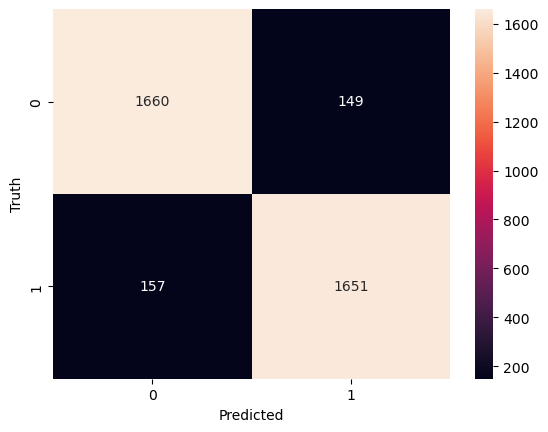

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1809
           1       0.92      0.91      0.92      1808

    accuracy                           0.92      3617
   macro avg       0.92      0.92      0.92      3617
weighted avg       0.92      0.92      0.92      3617



In [92]:
# Sanity Check
y_pred = baseline_LR_model_tfidf_samples.predict(X_test_tfidf_samples)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print(classification_report(y_test, y_pred))

The recall scores here are remarkebly consistent. The model seems quite robust when looking at an even subsampled dataset, lending credibility to word choice indeed being quite predictive of class.

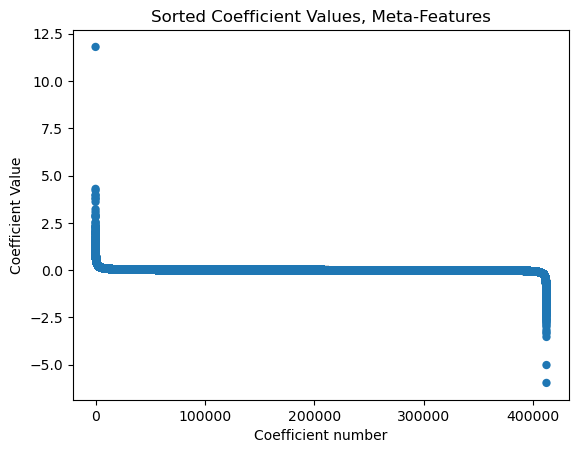

In [108]:
# Creating a coefficients DataFrame
coefficients = pd.DataFrame()
coefficients['Feature'] = text_pipeline_samples.get_feature_names_out()
coefficients['Coefficients'] = baseline_LR_model_tfidf_samples.coef_[0]
coefficients = coefficients.sort_values('Coefficients', ascending = False).reset_index(drop = True)
coefficients['Examples'] = coefficients['Feature'].apply(lambda txt: Stemmer_Dictionary[txt])
coefficients = coefficients.sort_values('Coefficients', ascending = False)

# Plotting
sns.scatterplot(x = range(coefficients.shape[0]), y = coefficients['Coefficients'], edgecolor='None')
plt.title('Sorted Coefficient Values, Meta-Features')
plt.xlabel('Coefficient number')
plt.ylabel('Coefficient Value')
plt.show()

We see a similar pattern here as before.

In [94]:
# Assigning top and bottom 100 coefficients
top_100 = coefficients[:100]
bottom_100 = coefficients[-100:]

The TF-IDF model for this sample also suggests that references to the past and formal terms are more predictive of Good articles, though some terms related to miscellaneous topics like war, sports, and nature appear as well, perhaps indicating that these articles tend to be more documentative in topic.

In [95]:
top_100

,Feature,Coefficients,Examples
0,wa,11.801933,"{Was, was, WA, WAS, wa, Wa, wAS}"
1,describ,4.297055,"{describable, describ, described, Describing, ..."
2,episod,4.209673,"{episodes, Episodic, EPISODE, Episodes, episod..."
3,speci,3.960972,"{specie, species, Specie, Species}"
4,song,3.958380,"{SONGS, Songs, Songe, Song, SONG, songs, song,..."
5,review,3.794074,"{REVIEW, reviews, Reviewed, reviewability, rev..."
6,rout,3.772553,"{routed, Routed, routing, ROUTES, ROUTE, route..."
7,note,3.608328,"{NOTES, note, notes, Noted, NOTE, Noting, note..."
8,highway,3.217689,"{highway, HighWay, highways, Highways, Highway}"
9,prais,3.069686,"{praise, praising, Praised, praised, Praise, p..."


Promotional articles in the sample also tend to make more references to current events, organizations, corporate occupations. The meta-feature analysis over the sample shows similar results to before, though here much more emphasis is placed on the use of dates and stop words for Promotional articles. The neural network models also show similar results as before.

In [96]:
bottom_100

,Feature,Coefficients,Examples
411992,"2017,",-1.291090,"{2017,}"
411993,recent,-1.299446,"{recenters, Recently, recentered, Recent, rece..."
411994,la,-1.309141,"{laed, Las, la, La, LA, LAs, LAS, las, Laing}"
411995,resort,-1.316139,"{resort, resorted, Resort, Resorting, resortin..."
411996,releas,-1.316447,"{Releases, release, releases, releasing, Relea..."
411997,innov,-1.321170,"{innovative, innovator, INNOVATION, Innovative..."
411998,centr,-1.328066,"{centring, Centred, CENTRE, centred, centres, ..."
411999,partnership,-1.334916,"{Partnership, partnerships, partnership, PARTN..."
412000,2017,-1.338722,"{2017s, 2017}"
412001,applic,-1.342213,"{applicability, applicants, applications, appl..."


Let us now model over the meta-features.

In [109]:
# Dropping non-numeric columns
good_meta_features_samples = good_samples.drop(columns = ['text', 'url', 'text_list', 'readability_scores', 'Spacy Object'])
promotional_meta_features_samples = promo_samples.drop(columns = ['text', 'url', 'text_list', 'readability_scores', 'Spacy Object'])

In [ ]:
# Getting rid of invariate features
if list(good_meta_features_samples.columns[good_meta_features_samples.max() == good_meta_features_samples.min()]) == list(promotional.columns[promotional.max() == promotional.min()]) :

    good_meta_features_samples = good_meta_features_samples.drop(columns=list(good_meta_features_samples.columns[good_meta_features_samples.max() == good_meta_features_samples.min()]))
    promotional_meta_features_samples = promotional_meta_features_samples.drop(columns=list(promotional.columns[promotional.max() == promotional.min()]))

    
    good_meta_features_samples.to_csv('good_meta_features_samples.csv')
    promotional_meta_features_samples.to_csv('promotional_meta_features_samples.csv')

In [110]:
# Read for convenience
good_meta_features_samples = pd.read_csv('good_meta_features_samples.csv').drop(columns = ['Unnamed: 0'])
promotional_meta_features_samples = pd.read_csv('promotional_meta_features_samples.csv').drop(columns = ['Unnamed: 0'])

# Sanity Check
good_meta_features_samples['is_not_promo'] = 1
promotional_meta_features_samples['is_not_promo'] = 0

In [112]:
# Resplitting Data
all_articles = pd.concat([good_meta_features_samples, promotional_meta_features_samples]).reset_index(drop = True)

X = all_articles.drop(columns=['is_not_promo'])
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify = y)

# Instantiating Logistic regression model
baseline_LR_model_meta_features_samples = LogisticRegression()
baseline_LR_model_meta_features_samples.fit(X_train, y_train)

# Training and test score
print(f"Train score: {baseline_LR_model_meta_features_samples.score(X_train, y_train)}")
print(f"Test score: {baseline_LR_model_meta_features_samples.score(X_test, y_test)}")

Train score: 0.8455104721089376
Test score: 0.8354990323472491


The accuracy here has dropped significantly, which makes sense because we intentionally normalized over some critical meta-features. However, this accuracy still indicates that meta-features are still different enough between the two datasets to have predictive power.

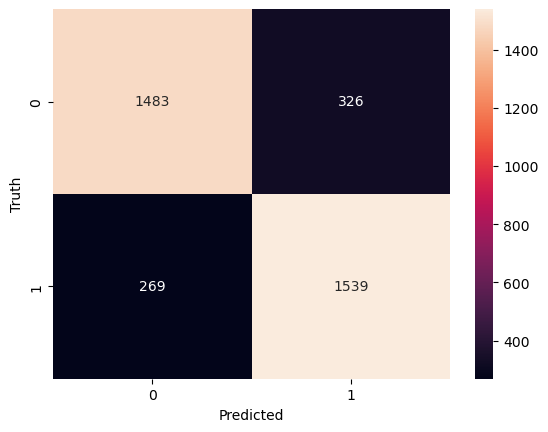

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1809
           1       0.83      0.85      0.84      1808

    accuracy                           0.84      3617
   macro avg       0.84      0.84      0.84      3617
weighted avg       0.84      0.84      0.84      3617



In [113]:
# Displaying Confusion Matrix and Classification Report
y_pred = baseline_LR_model_meta_features_samples.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print(classification_report(y_test, y_pred))

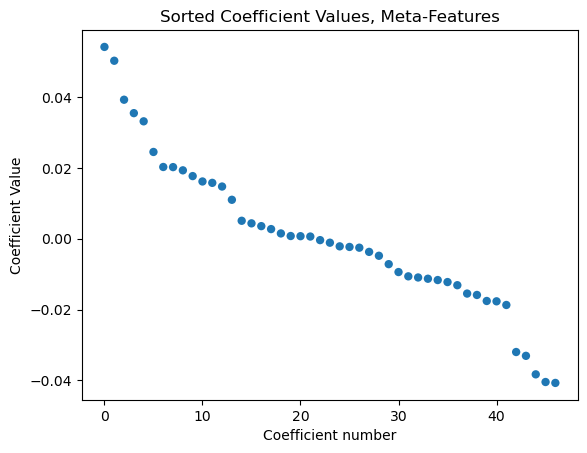

In [114]:
# Creating a coefficients DataFrame
coefficients = pd.DataFrame()
coefficients['Feature'] = good_meta_features_samples.columns[:-1]
coefficients['Coefficients'] = baseline_LR_model_meta_features_samples.coef_[0]
coefficients['Explanations'] = coefficients['Feature'].apply(lambda txt: GLOSSARY[txt] if txt in GLOSSARY else txt)
coefficients = coefficients.sort_values('Coefficients', ascending = False).reset_index(drop = True)

# Plotting
sns.scatterplot(x = range(coefficients.shape[0]), y = coefficients['Coefficients'], edgecolor='None')
plt.title('Sorted Coefficient Values, Meta-Features')
plt.xlabel('Coefficient number')
plt.ylabel('Coefficient Value')
plt.show()

The coefficient distribution looks similar to before, perhaps suggesting that some rules stayed consistent.

Looking directly at the coefficients below, shows similarities, with notable exceptions such as much more emphasis being placed on dates and stop words for promotional articles, and Flesch score now having a positive coefficient.

In [115]:
coefficients

,Feature,Coefficients,Explanations
0,SCONJ,0.054146,subordinating conjunction
1,ADP,0.050242,adposition
2,QUANTITY,0.039237,"Measurements, as of weight or distance"
3,flesch_score,0.035449,flesch_score
4,DET,0.033138,determiner
5,PART,0.024489,particle
6,NUM,0.020246,numeral
7,PERSON,0.020212,"People, including fictional"
8,NORP,0.019300,Nationalities or religious or political groups
9,PUNCT,0.017674,punctuation


Let us make use of BERT again.

In [116]:
# Splitting text

# In hindsight, I should have saved the indices for the samples somewhere 
# and used those to fetch the appropriate embeddings instead of having them recalculated.

all_articles = pd.concat([good_samples[['text', 'is_not_promo']], promo_samples[['text', 'is_not_promo']]]).reset_index(drop = True)

all_articles["text_ls"] = all_articles["text"].apply(lambda txt: txt.split(' '))
all_articles["beg"] = all_articles["text_ls"].apply(lambda txt: ' '.join(txt[:126]))
all_articles["mid"] = all_articles["text_ls"].apply(lambda txt: ' '.join(txt[round(len(txt)/2)-63:round(len(txt)/2)+64]))
all_articles["end"] = all_articles["text_ls"].apply(lambda txt: ' '.join(txt[-126:]))
all_articles

,text,is_not_promo,text_ls,beg,mid,end
0,"Reviewer Basilisk4u talk contribs 22 08, 11 No...",1,"[Reviewer, Basilisk4u, talk, contribs, 22, 08,...","Reviewer Basilisk4u talk contribs 22 08, 11 No...",article is interesting and has a lot of potent...,review it for GA. Please bear with me as I cur...
1,M 144 was the designation assigned to two form...,1,"[M, 144, was, the, designation, assigned, to, ...",M 144 was the designation assigned to two form...,km spur connecting the Michigan State Police h...,"1939, after which time the designation was shi..."
2,M 147 was a state trunkline highway in the U.S...,1,"[M, 147, was, a, state, trunkline, highway, in...",M 147 was a state trunkline highway in the U.S...,Michigan. The route of M 147 was transferred t...,"Southern Michigan property. From there, the tr..."
3,M 105 was the designation of a former state tr...,1,"[M, 105, was, the, designation, of, a, former,...",M 105 was the designation of a former state tr...,M 83 now M 142 near Elkton. The designation wa...,53 Van Dyke Road in the small community of Pop...
4,Nepal sent a delegation to compete at the 2010...,1,"[Nepal, sent, a, delegation, to, compete, at, ...",Nepal sent a delegation to compete at the 2010...,"only event, the 15 kilometre freestyle Nepal f...",Games since the 1972 edition. Nepal did not en...
...,...,...,...,...,...,...
18079,The American University AU or American is a pr...,0,"[The, American, University, AU, or, American, ...",The American University AU or American is a pr...,University was named the most politically acti...,"can be a serious drama, but has playful aspect..."
18080,The following are fictional characters from Di...,0,"[The, following, are, fictional, characters, f...",The following are fictional characters from Di...,"all English language media, Meg is voiced by S...",an eagle every day forever. A bronze statue of...
18081,Sonic Youth was an American rock band based in...,0,"[Sonic, Youth, was, an, American, rock, band, ...",Sonic Youth was an American rock band based in...,from the band. They also performed the final c...,"even other media, drawing influence from the w..."
18082,"Songpa gu is a district of Seoul, South Korea....",0,"[Songpa, gu, is, a, district, of, Seoul,, Sout...","Songpa gu is a district of Seoul, South Korea....",is planning to be the mecca of artistic perfor...,"8 km section, is scheduled to be completed by ..."


In [ ]:
# Embedding text
three_part_embeddings_samples = pd.concat([get_embeddings_of_series(all_articles['beg']), get_embeddings_of_series(all_articles["mid"]), get_embeddings_of_series(all_articles["end"])], axis=1)
three_part_embeddings_samples.columns = range(768*3)
three_part_embeddings_samples.to_csv('three_part_embeddings_samples.csv')

three_part_embeddings_samples.head()

In [117]:
# Read for convenience
three_part_embeddings_samples  = pd.read_csv('three_part_embeddings_samples.csv').drop(columns = ['Unnamed: 0'])
three_part_embeddings_samples.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2183,2184,2185,2186,2187,2188,2189,2190,2191,2192,2193,2194,2195,2196,2197,2198,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215,2216,2217,2218,2219,2220,2221,2222,2223,2224,2225,2226,2227,2228,2229,2230,2231,2232,2233,2234,2235,2236,2237,2238,2239,2240,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256,2257,2258,2259,2260,2261,2262,2263,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,-0.725305,-0.585967,-0.983590,0.755452,0.845468,-0.154148,0.533731,0.442276,-0.930395,-0.999954,-0.616440,0.972109,0.952284,0.718681,0.780213,-0.459844,-0.146595,-0.641219,0.459766,0.660986,0.639206,1.000000,-0.345974,0.435226,0.483192,0.997435,-0.823614,0.851720,0.900019,0.532259,-0.513359,0.365008,-0.981579,-0.417253,-0.992657,-0.990493,0.617220,-0.414424,0.076766,0.101061,-0.767528,0.382234,0.999984,0.156626,0.744348,-0.170567,-1.000000,0.401423,-0.798125,0.954972,0.941762,0.984565,0.181279,0.476498,0.520979,-0.299679,0.042489,0.129228,-0.350358,-0.606531,-0.607376,0.621149,-0.935740,-0.890423,0.948400,0.954772,-0.339618,-0.385385,-0.085971,-0.166455,0.658430,0.470958,-0.492950,-0.905118,0.806362,0.388840,-0.739322,1.000000,-0.545008,-0.945670,0.991332,0.909850,0.572419,-0.586545,0.785559,-1.000000,0.599197,-0.283746,-0.974681,0.320084,0.672314,-0.144278,0.975206,0.642730,-0.678626,-0.764071,-0.308968,-0.948522,-0.487894,-0.550127,0.381691,-0.296846,-0.503059,-0.453020,0.412523,-0.600239,-0.286971,0.821246,0.404186,0.670998,0.562672,-0.541453,0.444986,-0.912749,0.601349,-0.435941,-0.966541,-0.619943,-0.969557,0.738153,-0.399580,-0.347193,0.855364,-0.826218,0.572878,-0.322616,-0.984955,-1.0,-0.709124,-0.728063,-0.549517,-0.395595,-0.918711,-0.939622,0.650709,0.843381,0.303829,0.999926,-0.403605,0.929922,-0.524790,-0.863614,0.791208,-0.534424,0.904450,-0.287293,-0.358734,0.178007,-0.661769,0.669981,-0.887858,-0.208275,-0.905080,-0.853311,-0.455555,0.913026,-0.832069,-0.978809,-0.421752,-0.068705,-0.351328,0.733718,0.814768,0.478563,-0.651661,0.547901,0.454404,0.551101,-0.548093,-0.445680,0.393294,-0.453115,-0.981145,-0.964273,-0.388473,0.599402,0.962384,0.492103,0.403898,0.879151,-0.235462,0.885100,-0.937035,0.950698,-0.199131,0.436644,-0.858459,0.872593,-0.649491,0.494108,0.665695,-0.865922,-0.658178,-0.195330,-0.587033

Training Accuracy
453/453 [==============================] - 1s 3ms/step - loss: 0.1598 - accuracy: 0.9379
Testing Accuracy
114/114 [==============================] - 0s 3ms/step - loss: 0.2060 - accuracy: 0.9231




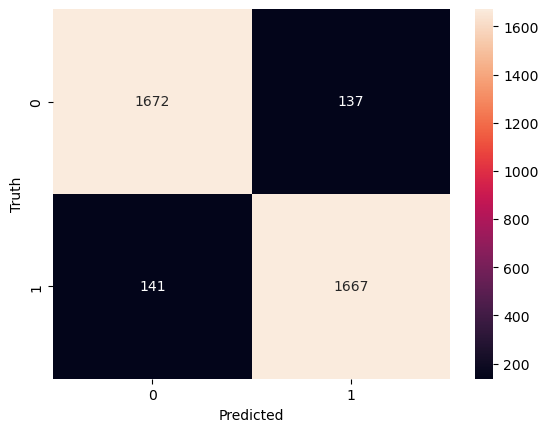



              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1809
           1       0.92      0.92      0.92      1808

    accuracy                           0.92      3617
   macro avg       0.92      0.92      0.92      3617
weighted avg       0.92      0.92      0.92      3617



In [144]:
# Test NN using all 3 text sections

X = three_part_embeddings_samples
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify=y)

BERT_model_all_samples = BERT_encoded_model(X_train, X_test, y_train, y_test, layers = 3, epochs = 5, verbose = 0)

BERT embeddings are still quite powerful at this level, which makes sense since not much has changed from its perspective. The rest of the trials below are also relatively unchanged.

Training Accuracy
453/453 [==============================] - 1s 3ms/step - loss: 0.1918 - accuracy: 0.9248
Testing Accuracy
114/114 [==============================] - 0s 3ms/step - loss: 0.2100 - accuracy: 0.9187




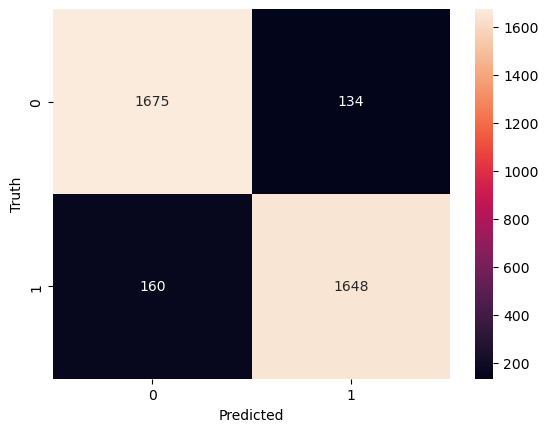



              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1809
           1       0.92      0.91      0.92      1808

    accuracy                           0.92      3617
   macro avg       0.92      0.92      0.92      3617
weighted avg       0.92      0.92      0.92      3617



In [145]:
# Test NN using only beginnings

X = three_part_embeddings_samples[[str(i) for i in range(768)]]
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify=y)

BERT_model_beg_samples = BERT_encoded_model(X_train, X_test, y_train, y_test, layers = 3, epochs = 15, verbose = 0)

Training Accuracy
453/453 [==============================] - 1s 3ms/step - loss: 0.1746 - accuracy: 0.9328
Testing Accuracy
114/114 [==============================] - 0s 3ms/step - loss: 0.2484 - accuracy: 0.9005




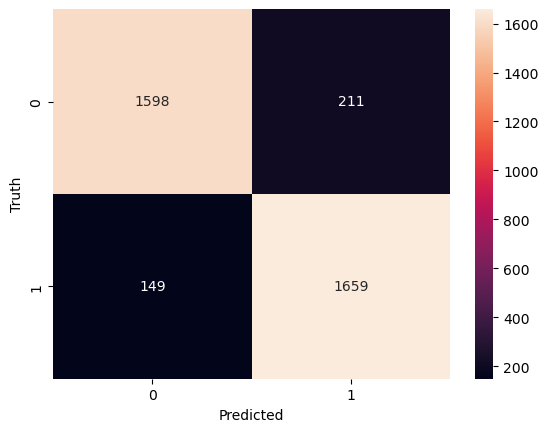



              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1809
           1       0.89      0.92      0.90      1808

    accuracy                           0.90      3617
   macro avg       0.90      0.90      0.90      3617
weighted avg       0.90      0.90      0.90      3617



In [146]:
# Test NN using only middles

X = three_part_embeddings_samples[[str(i) for i in range(768,768*2)]]
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify=y)

BERT_model_mid_samples = BERT_encoded_model(X_train, X_test, y_train, y_test, layers = 3, epochs = 15, verbose = 0)

Training Accuracy
453/453 [==============================] - 1s 3ms/step - loss: 0.1821 - accuracy: 0.9276
Testing Accuracy
114/114 [==============================] - 0s 3ms/step - loss: 0.2484 - accuracy: 0.9032




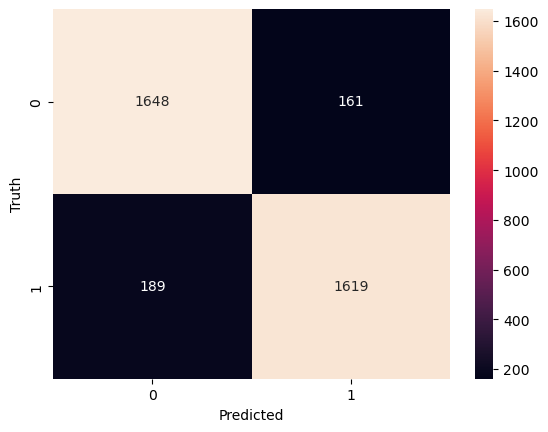



              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1809
           1       0.91      0.90      0.90      1808

    accuracy                           0.90      3617
   macro avg       0.90      0.90      0.90      3617
weighted avg       0.90      0.90      0.90      3617



In [147]:
# Test NN using only endings

X = three_part_embeddings_samples[[str(i) for i in range(768*2,768*3)]]
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify=y)

BERT_model_end_samples = BERT_encoded_model(X_train, X_test, y_train, y_test, layers = 3, epochs = 15, verbose = 0)

### Testing models trained on samples on the larger test sets

Let us now put the above models to a more interesting applciation, that is, predicting over the whole dataset, instead of just the subsample. We will compare with the same test set used by the original models.

There is actually an error in the methodology caught here that wasn't caught until review, being that the subsampled data was sampled from the data as a whole, rather than the test data, and so the models below are likely to have used a portion of the testing data for training, making these accuracies perhaps more optimistic than they should really be. Nevertheless, the performance deviations are still large enough to be taken note of.

In [148]:
# Resplitting Data
all_articles = pd.concat([good, promotional]).reset_index(drop = True)

X = all_articles.drop(columns = ['is_not_promo'])
y = list(all_articles['is_not_promo'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify = y)

In [154]:
# Transforming data for the subsample
X_test_tfidf_samples_TEST = text_pipeline_samples.transform(list(X_test['text']))

In [ ]:
# Saving Data
sparse.save_npz("X_test_tfidf_samples_TEST.npz", X_test_tfidf_samples_TEST)

In [155]:
# Reading in data for convenience
sparse.save_npz("X_test_tfidf_samples_TEST.npz", X_test_tfidf_samples_TEST)

In [156]:
# Creating meta features data
X_test_meta_features_samples_TEST = X_test[good_meta_features.columns[:-1]]

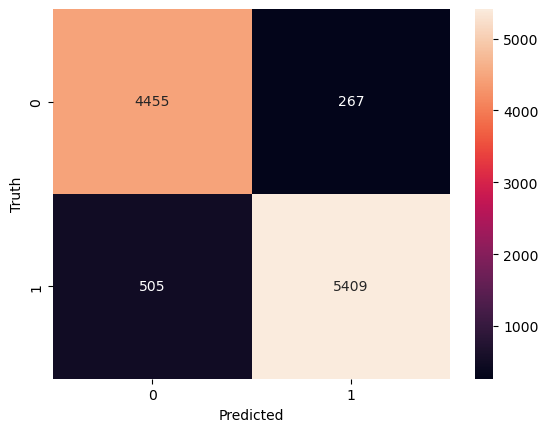

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4722
           1       0.95      0.91      0.93      5914

    accuracy                           0.93     10636
   macro avg       0.93      0.93      0.93     10636
weighted avg       0.93      0.93      0.93     10636





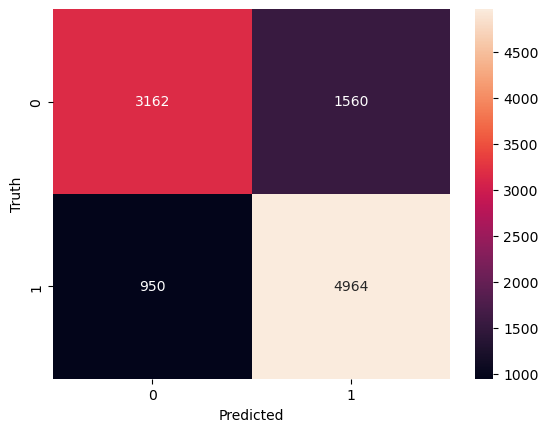

              precision    recall  f1-score   support

           0       0.77      0.67      0.72      4722
           1       0.76      0.84      0.80      5914

    accuracy                           0.76     10636
   macro avg       0.76      0.75      0.76     10636
weighted avg       0.76      0.76      0.76     10636



In [157]:
# TF-IDF subsample model predicting outside values
y_pred = baseline_LR_model_tfidf_samples.predict(X_test_tfidf_samples_TEST)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print(classification_report(y_test, y_pred))
print('\n')

# Meta-feature subsample model predicting outside values
y_pred = baseline_LR_model_meta_features_samples.predict(X_test_meta_features_samples_TEST)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print(classification_report(y_test, y_pred))

The TF-IDF performance is still high, probably due to the subsampled dataset containing many of the predictive words that the rest of the dataset has.

Very interestingly, the meta-feature trained model performs quite poorly, compared to all the other models. The recall score indicates that it can still capture a good proportion of good articles, but it performs considerably worse on promotional articles. This suggests that promotional articles of different lengths tend to employ very different uses of metafeatures.

In [ ]:
# Splitting embedding data
X = three_part_embeddings
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify=y)

# Scaling data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

The BERT tests below are quire interesting. The model which was trained on beginning, middle, and end actually has the *lowest* overall accuracy. The beginning and middle networks still perform quite well. The ending network performs notably worse, perhaps suggesting that articles of different lengths tend to end in significantly different ways.

It seems that when extrapolating, it is better to use subsamples of text rather than extractions from different parts to make predictions with.

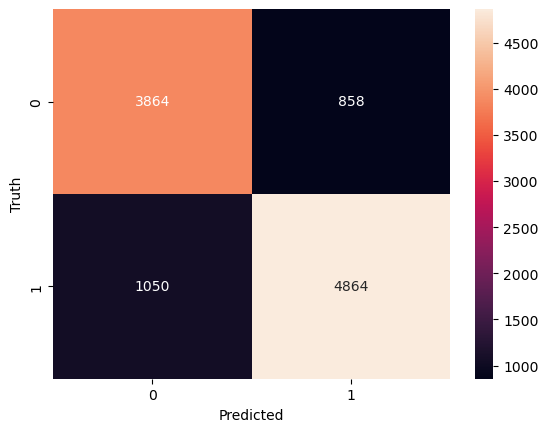



              precision    recall  f1-score   support

           0       0.79      0.82      0.80      4722
           1       0.85      0.82      0.84      5914

    accuracy                           0.82     10636
   macro avg       0.82      0.82      0.82     10636
weighted avg       0.82      0.82      0.82     10636





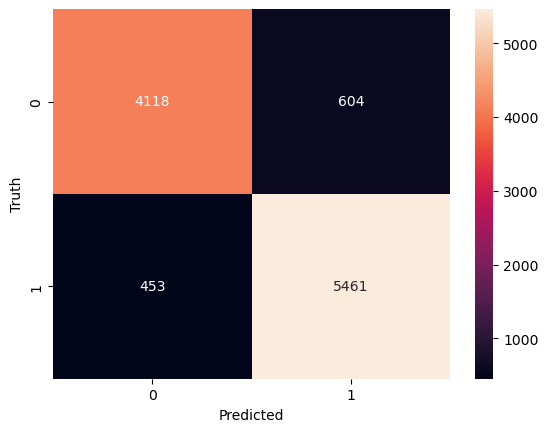



              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4722
           1       0.90      0.92      0.91      5914

    accuracy                           0.90     10636
   macro avg       0.90      0.90      0.90     10636
weighted avg       0.90      0.90      0.90     10636





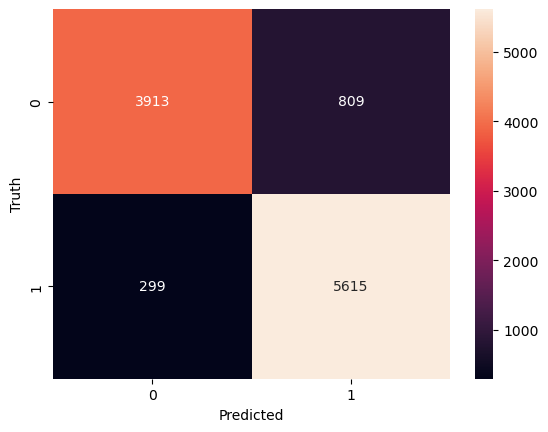



              precision    recall  f1-score   support

           0       0.93      0.83      0.88      4722
           1       0.87      0.95      0.91      5914

    accuracy                           0.90     10636
   macro avg       0.90      0.89      0.89     10636
weighted avg       0.90      0.90      0.90     10636





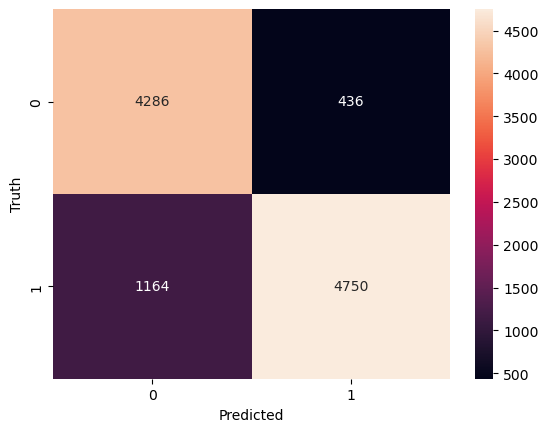



              precision    recall  f1-score   support

           0       0.79      0.91      0.84      4722
           1       0.92      0.80      0.86      5914

    accuracy                           0.85     10636
   macro avg       0.85      0.86      0.85     10636
weighted avg       0.86      0.85      0.85     10636



In [159]:
# Plotting performances of subsample neural networks on outside data
plot_NN(BERT_model_all_samples, X_test, y_test)
print('\n')
plot_NN(BERT_model_beg_samples, X_test[[str(i) for i in range(768)]], y_test)
print('\n')
plot_NN(BERT_model_mid_samples, X_test[[str(i) for i in range(768,768*2)]], y_test)
print('\n')
plot_NN(BERT_model_end_samples, X_test[[str(i) for i in range(768*2,768*3)]], y_test)

# Model Optimization

Let us now engineer a model purely for predictive power over the dataset. We will first take the TF-IDF features from before and truncate them down to the most predictive terms, in the interest of completing a PCA dimensionality reduction algorithm before the heat death of the universe.

In [118]:
# Taking another look at original TF-IDF logistic regression coefficients
coefficients = pd.DataFrame()
coefficients['Feature'] = text_pipeline.get_feature_names_out()
coefficients['Coefficients'] = baseline_LR_model_tfidf.coef_[0]

In [119]:
# Selecting upper and lower quantiles
print(coefficients['Coefficients'].quantile(.005))
print(coefficients['Coefficients'].quantile(.995))

-0.17032973660450168
0.2667632397800356


In [121]:
coefficients.shape

(958297, 2)

In [134]:
# Removing all but the coefficients in the selected quantiles
coef = coefficients
bools = ((coef['Coefficients'].abs() <= coef['Coefficients'].abs().quantile(0.005)) | (coef['Coefficients'].abs() >= coef['Coefficients'].abs().quantile(.995)))
X_train_temp = X_train_tfidf[:,bools]
X_test_temp = X_test_tfidf[:,bools]

coef = coef[bools]
coef.shape

(9595, 2)

The number of dimensions has been to the top 1% most deviant values.

Let us concatenate this data with the other features, those being the meta-features and the 3 sets of embeddings.

In [123]:
# Resplitting and combining all data - TF-iDF (reduced), meta-features, and 3-part embeddings
all_articles = pd.concat([good_meta_features, promotional_meta_features]).reset_index(drop = True)

X = three_part_embeddings

X = pd.concat([all_articles.drop(columns=['is_not_promo']).reset_index(drop = True), three_part_embeddings], axis=1)
y = all_articles['is_not_promo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2697, stratify = y)

X_train = sparse.hstack([sparse.csr_matrix(X_train), X_train_temp])
X_test = sparse.hstack([sparse.csr_matrix(X_test), X_test_temp])

In [ ]:
# Saving data
sparse.save_npz("X_train.npz", X_train)
sparse.save_npz("X_test.npz", X_test)

y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

In [124]:
# Reading in data for convenience
X_train = sparse.load_npz("X_train.npz")
X_test = sparse.load_npz("X_test.npz")

In [125]:
# Converting sparse matrices to DataFrames for convenience
X_train = pd.DataFrame(X_train.toarray())
X_test = pd.DataFrame(X_test.toarray())

In [126]:
# Sanity Check
print(X_train.shape)
print(X_test.shape)

(42540, 11946)
(10636, 11946)


We now have about 12,00 features, which is still a lot, though much less than 1 million, and notably less than the number of datapoints available.

In [127]:
# Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [128]:
# PCA instantiating and fitting
PCA = PCA()
PCA.fit(X_train)

PCA()

Let us see how our PCA has performed.

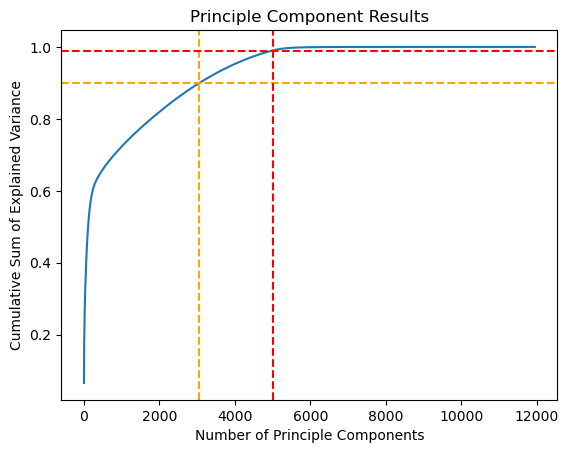

In [129]:
# Pull out the explained variance ratio
expl_var = PCA.explained_variance_ratio_

# Calculate the cumulative sum of this array using the 
cumulative_sum = np.cumsum(expl_var)

# Plot out the cumulative sum graph
plt.figure()
plt.plot(range(1, 1 + len(cumulative_sum)), cumulative_sum)
plt.axvline(3062, c='orange', linestyle='--')
plt.axhline(0.9, c='orange', linestyle='--')
plt.axhline(0.99, c='r', linestyle='--')
plt.axvline(4998, c='r', linestyle='--')
plt.title('Principle Component Results')
plt.xlabel('Number of Principle Components')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.show()

In [130]:
# Printing a sample of values
print(np.array(range(1, 1 + len(cumulative_sum)))[cumulative_sum>0.8][0])
print(np.array(range(1, 1 + len(cumulative_sum)))[cumulative_sum>0.9][0])
print(np.array(range(1, 1 + len(cumulative_sum)))[cumulative_sum>0.99][0])

1779
3062
4998


Our PCA has significantly restructured our data, such that 99% of variance is stored in under 50% of the features. Let us however see what number of PCs is optimal to avoid overfitting. We shall split our training data into a validation set for this.

In [ ]:
# transform data 
X_train_PCA = sparse.csr_matrix(PCA.transform(X_train))
X_test_PCA = sparse.csr_matrix(PCA.transform(X_test))

sparse.save_npz("X_train_PCA.npz", X_train_PCA)
sparse.save_npz("X_test_PCA.npz", X_test_PCA)

In [135]:
# Reading in data for convenience
X_train_PCA = sparse.load_npz("X_train_PCA.npz")
X_test_PCA = sparse.load_npz("X_test_PCA.npz")

In [136]:
# Reading in data for convenience
y_train = pd.read_csv('y_train.csv').drop(columns = ['Unnamed: 0'])['is_not_promo']
y_test = pd.read_csv('y_test.csv').drop(columns = ['Unnamed: 0'])['is_not_promo']

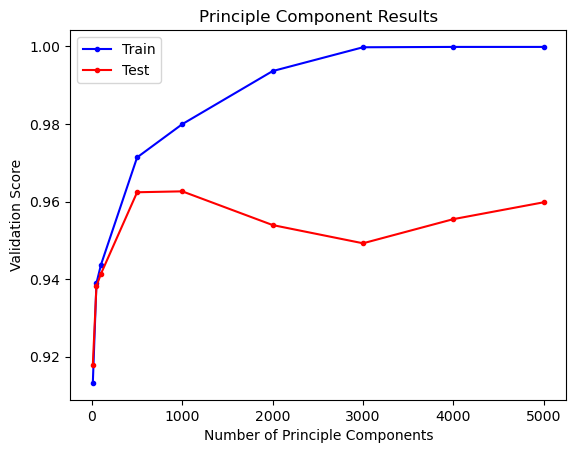

In [137]:
# Splitting training data into validation sets in order to test for optimal PCA value
X_train_validation, X_validation, y_train_validation, y_validation = train_test_split(X_train_PCA, y_train, test_size=0.2, random_state=2697, stratify = y_train)

train_scores = []
test_scores = []
PCA_range = [10,50,100,500,1000,2000,3000,4000,5000]

for i in PCA_range :
    # Instantiating Logistic regression model
    baseline_LR_model_PCA = LogisticRegression()
    baseline_LR_model_PCA.fit(X_train_validation[:, :i], y_train_validation)
    
    # Storing performances
    train_scores.append(baseline_LR_model_PCA.score(X_train_validation[:, :i], y_train_validation))
    test_scores.append(baseline_LR_model_PCA.score(X_validation[:, :i], y_validation))

# Plotting 
plt.plot(PCA_range,train_scores, color = 'b', marker = '.', label = 'Train')
plt.plot(PCA_range,test_scores, color = 'r', marker = '.', label = 'Test')
plt.title('Principle Component Results')
plt.xlabel('Number of Principle Components')
plt.ylabel('Validation Score')
plt.legend()
plt.show()

Looking broadly, though 99% of variance was stored in about 5000 datapoints, at that end we see a lot of overfitting in the data, since the training accuracy at that point deviates far from the testing. Interestingly, we see a bend in the testing curve between 1000 and 5000 PCs.

Let us take a closer look with the PCs under 1000, since testing accuracy peaks here and deviates less from training.

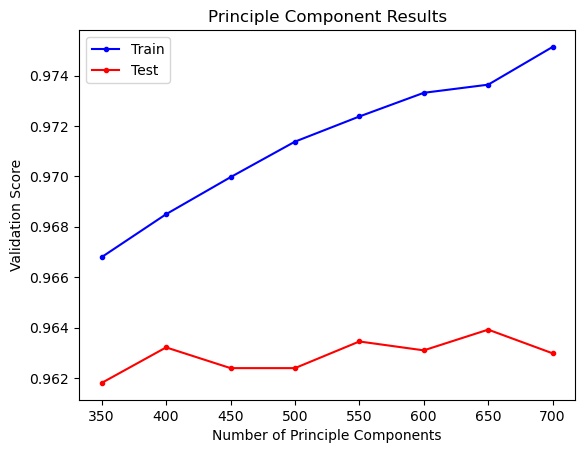

In [138]:
# Splitting training data into validation sets in order to test for optimal PCA value
X_train_validation, X_validation, y_train_validation, y_validation = train_test_split(X_train_PCA, y_train, test_size=0.2, random_state=2697, stratify = y_train)

train_scores = []
test_scores = []
PCA_range = range(350,750,50)

for i in PCA_range :
    # Instantiating Logistic regression model
    baseline_LR_model_PCA = LogisticRegression()
    baseline_LR_model_PCA.fit(X_train_validation[:, :i], y_train_validation)
    
    # Storing performances
    train_scores.append(baseline_LR_model_PCA.score(X_train_validation[:, :i], y_train_validation))
    test_scores.append(baseline_LR_model_PCA.score(X_validation[:, :i], y_validation))

# Plotting 
plt.plot(PCA_range,train_scores, color = 'b', marker = '.', label = 'Train')
plt.plot(PCA_range,test_scores, color = 'r', marker = '.', label = 'Test')
plt.title('Principle Component Results')
plt.xlabel('Number of Principle Components')
plt.ylabel('Validation Score')
plt.legend()

We see that testing accuracy is around the same for PCs in this range. I shall select 400 PCs, because though it isn't the most accurate, it is quite powerful and has a large proportion less features than the higher peaks of 550 and 650, which will be helpful to modeling in a reasonable time frame.

XGBoost
The best score across ALL searched params:
 0.9635872120357311
The best parameters across ALL searched params:
 {'n_estimators': 120}
time taken = 20.8s


Logistic Regression
The best score across ALL searched params:
 0.9655148095909732
The best parameters across ALL searched params:
 {'C': 0.001}
time taken = 18.5s


KNN
The best score across ALL searched params:
 0.9209449929478138
The best parameters across ALL searched params:
 {'n_neighbors': 3}
time taken = 36.4s


Decision Tree
The best score across ALL searched params:
 0.9236953455571226
The best parameters across ALL searched params:
 {'max_depth': 8}
time taken = 47.5s


Random Forest
The best score across ALL searched params:
 0.9370709920075223
The best parameters across ALL searched params:
 {'max_depth': 7, 'n_estimators': 100}
time taken = 127.2s


Naive Bayes
The best score across ALL searched params:
 0.894358251057828
The best parameters across ALL searched params:
 {}
time taken = 1.1s


SVM
The best score 

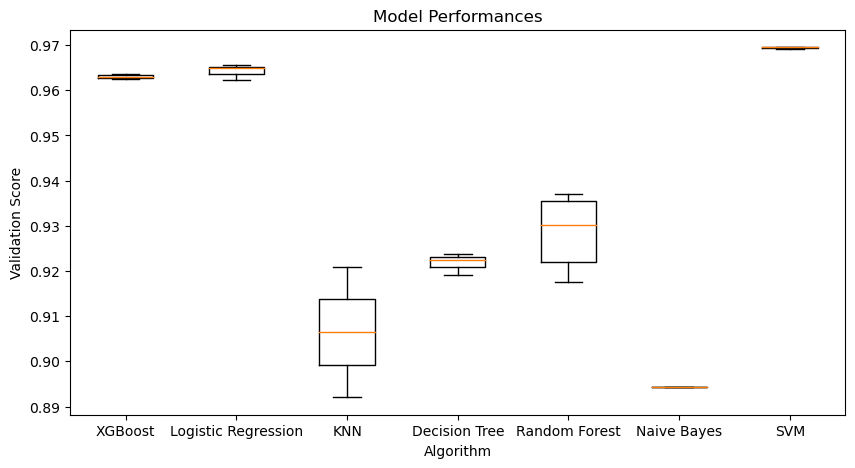

In [139]:
# Selecting first 400 PCA features
X_train_HP = X_train_PCA[:, :400]
y_train_HP = y_train

# Creating models dictionary
models = {
          'XGBoost' : XGBClassifier(tree_method='gpu_hist'),
          'Logistic Regression': LogisticRegression(max_iter=1000),
          'KNN': KNeighborsClassifier(),
          'Decision Tree' : DecisionTreeClassifier(),
          'Random Forest' : RandomForestClassifier(),
          'Naive Bayes' : BernoulliNB(),
          'SVM' : SVC()}

# Creating parameters dictionary
parameters = {
          'Logistic Regression': {'C' : [0.0001,0.001,0.01]},
          'KNN': {'n_neighbors' : [2,3,4]},
          'Decision Tree' : {'max_depth' : [8,10,12]},
          'Random Forest' : {'n_estimators' : [90,100],
                             'max_depth' : [3,5,7]},
          'XGBoost' : {'n_estimators' : [90,120]},
          'Naive Bayes' : {},
          'SVM' : {'C': [5,10,15]}}

# Creating KFolds object
kf = KFold(n_splits=5, random_state=2697, shuffle=True)

results = []

# Looping through models
for model_name in models:
    t0 = time.time()
    print(model_name)
    
    # Grid Search
    grid_search = GridSearchCV(estimator=models[model_name],
                               param_grid = parameters[model_name],
                               cv = kf, n_jobs = -1)
    grid_search.fit(X_train_HP, y_train_HP)

    results.append(grid_search.cv_results_)


    print('The best score across ALL searched params:\n',grid_search.best_score_)
    print('The best parameters across ALL searched params:\n',grid_search.best_params_)
    t1 = time.time()
    print('time taken = ' + str(round(t1-t0,1)) + 's')
    print('\n')

# Displaying results
test_scores = [results[i]['mean_test_score'] for i in range(len(models.keys()))]
plt.figure(figsize=(10, 5), dpi=100)
plt.boxplot(test_scores, labels=models.keys())
plt.title('Model Performances')
plt.xlabel('Algorithm')
plt.ylabel('Validation Score')
plt.show()

The top performers here are XGBoost, Logistic Regression, and SVM. In the next test, I will try to fine tune the top performers, and try and see if random forests performs better with some slight adjustments.

XGBoost
The best score across ALL searched params:
 0.9636342266102492
The best parameters across ALL searched params:
 {'n_estimators': 125}
time taken = 36.1s


Logistic Regression
The best score across ALL searched params:
 0.9655148095909732
The best parameters across ALL searched params:
 {'C': 0.001}
time taken = 27.3s


Random Forest
The best score across ALL searched params:
 0.9391161259990597
The best parameters across ALL searched params:
 {'max_depth': 8, 'n_estimators': 70}
time taken = 170.6s


SVM
The best score across ALL searched params:
 0.9695580629995298
The best parameters across ALL searched params:
 {'C': 11}
time taken = 530.3s




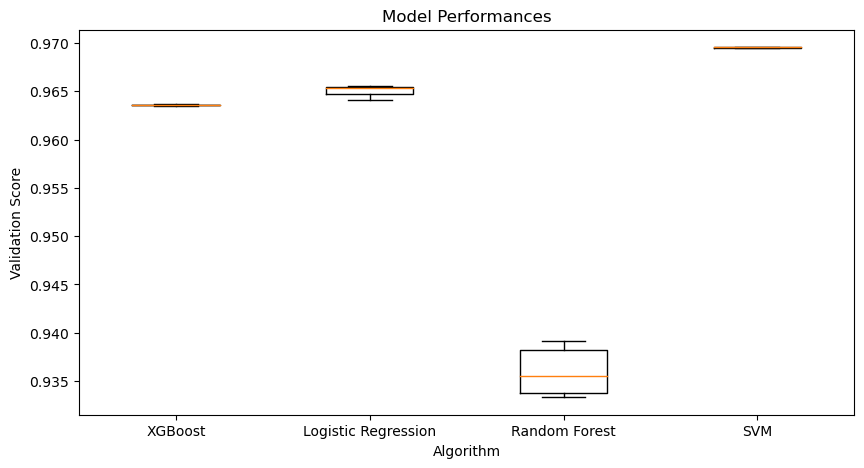

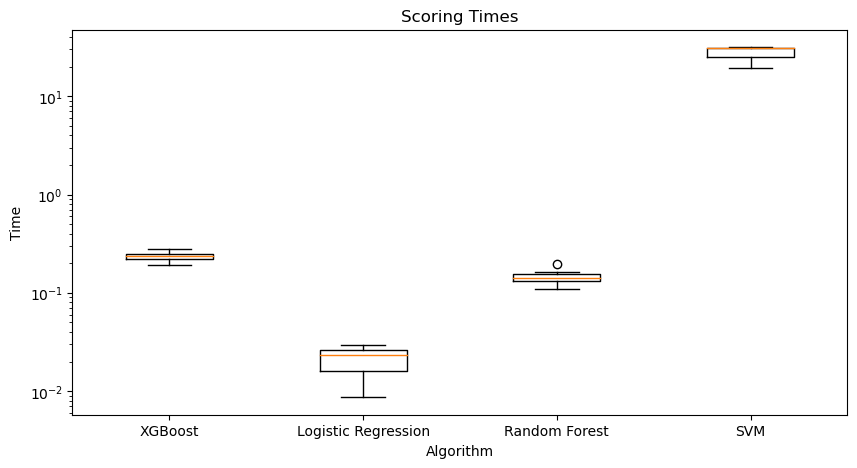

In [153]:
X_train_HP = X_train_PCA[:, :400]
y_train_HP = y_train

# Create models dictionary
models = {
          'XGBoost' : XGBClassifier(tree_method='gpu_hist'),
          'Logistic Regression': LogisticRegression(max_iter=1000),
          'Random Forest' : RandomForestClassifier(),
          'SVM' : SVC()}

# Creating parameters dictionary
parameters = {
          'Logistic Regression': {'C' : [0.0005,0.001,0.05]},
          'Random Forest' : {'n_estimators' : [70,80,90],
                             'max_depth' : [6,7,8]},
          'XGBoost' : {'n_estimators' : [115,120,125,130]},
          'SVM' : {'C': [9,10,11]}}

# Creating KFolds object
kf = KFold(n_splits=5, random_state=2697, shuffle=True)

results = []

# Loop through the models' values
for model_name in models:
    t0 = time.time()
    print(model_name)
    
    # Grid Search
    grid_search = GridSearchCV(estimator=models[model_name],
                               param_grid = parameters[model_name],
                               cv = kf, n_jobs = -1)
    grid_search.fit(X_train_HP, y_train_HP)

    results.append(grid_search.cv_results_)


    print('The best score across ALL searched params:\n',grid_search.best_score_)
    print('The best parameters across ALL searched params:\n',grid_search.best_params_)
    t1 = time.time()
    print('time taken = ' + str(round(t1-t0,1)) + 's')
    print('\n')


# Displaying accuracy results    
test_scores = [results[i]['mean_test_score'] for i in range(len(models.keys()))]
plt.figure(figsize=(10, 5), dpi=100)
plt.boxplot(test_scores, labels=models.keys())
plt.title('Model Performances')
plt.xlabel('Algorithm')
plt.ylabel('Validation Score')
plt.show()
print('\n')

# Displaying speed results 
test_scores = [results[i]['mean_score_time'] for i in range(len(models.keys()))]
plt.figure(figsize=(10, 5), dpi=100)
plt.boxplot(test_scores, labels=models.keys())
plt.title('Scoring Times')
plt.xlabel('Algorithm')
plt.ylabel('Time')
plt.yscale('log')
plt.show()

XGBoost, Logistic Regression, and SVM are still the top performers. SVM has the highest, at nearly 97% accuracy, but it also takes by far the longest to run. Logistic regression reaches almost just as high an accuracy, but runs *much* quicker, perhaps making it more favorable if computational cost and time is a concern.

Let us see how the best Logistic Regression and SVM models perform on the real test data.

In [113]:
# Selecting first 400 values from test features
X_test_HP = X_test_PCA[:,:400]
y_test_HP = y_test

Time taken: 0.008170127868652344


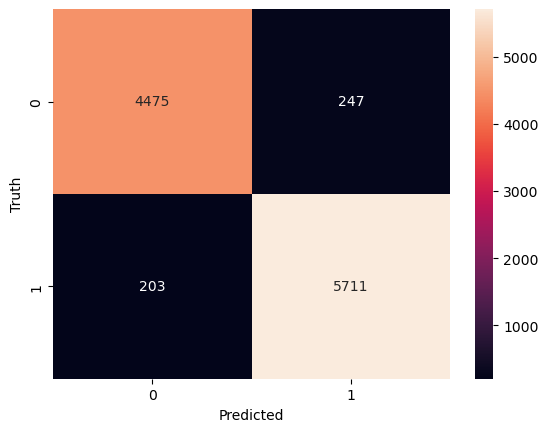

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4722
           1       0.96      0.97      0.96      5914

    accuracy                           0.96     10636
   macro avg       0.96      0.96      0.96     10636
weighted avg       0.96      0.96      0.96     10636



In [164]:
# Instantiating a fine tuned logistic regression model
Best_LogisticRegression = LogisticRegression(max_iter=1000, C = 0.001)
Best_LogisticRegression.fit(X_train_HP, y_train_HP)

t0 = time.time()
y_pred = Best_LogisticRegression.predict(X_test_HP)
t1 = time.time()
print('Time taken: ' + str(t1-t0))

# Plotting
sns.heatmap(confusion_matrix(y_test_HP, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print(classification_report(y_test_HP, y_pred))

Time taken: 10.705134630203247


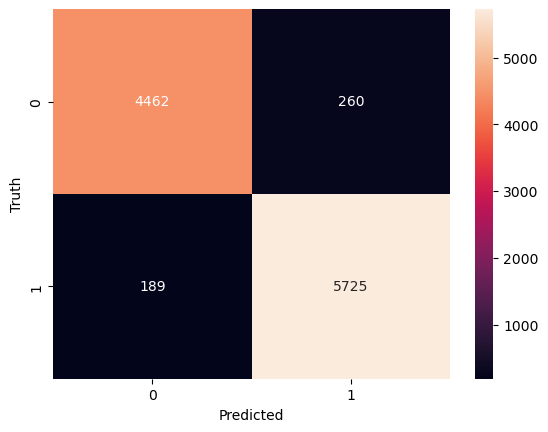

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4722
           1       0.96      0.97      0.96      5914

    accuracy                           0.96     10636
   macro avg       0.96      0.96      0.96     10636
weighted avg       0.96      0.96      0.96     10636



In [163]:
# Instantiating a fine tuned Support Vector Machine
Best_SVM = SVC(C = 11)
Best_SVM.fit(X_train_HP, y_train_HP)


t0 = time.time()
y_pred = Best_SVM.predict(X_test_HP)
t1 = time.time()
print('Time taken: ' + str(t1-t0))

# Plotting
sns.heatmap(confusion_matrix(y_test_HP, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print(classification_report(y_test_HP, y_pred))

Both models perform at around the same level, but Logistic regression is more consistent with its recall scores, and a few orders of magnitude quicker to predict, at least in this test. Practically speaking, the Logistic Regression model seems like the winner here.

Let us try fitting a feed forward neural network on the data as well.

In [107]:
def NN_Model(X_train, layers = 3, epochs = 5, verbose = 0):

    # Input
    embeddings_input = tf.keras.layers.Input(shape = (X_train.shape[1],), name='Inputs')

    # Layers
    for i in range(layers):
        layer = tf.keras.layers.Dropout(0.1)(embeddings_input)
        layer = tf.keras.layers.Dense(X_train.shape[1], activation='relu')(layer)

    layer = tf.keras.layers.Dropout(0.1)(layer)
    layer = tf.keras.layers.Dense(1, activation='sigmoid')(layer)

    # Model Construction
    model = tf.keras.Model(inputs=[embeddings_input], outputs = [layer])

    model.compile('adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
    
    return model

In [117]:
# Running a gridsearch over neural network layers and epochs

# Making a validation split
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_train_HP, y_train_HP, test_size=0.2, random_state=2697, stratify = y_train_HP)

parameters = []
test_results = []

for layers in [3,5,7,9,11] :
    for epochs in [5,10,15,20,25] :
        NN = NN_Model(X_train = X_train_NN, layers = layers, epochs = epochs, verbose = 0)
        
        NN.fit(X_train_NN, y_train_NN, epochs=epochs, verbose=0)
        
        parameters.append((layers,epochs))
        test_results.append(NN.evaluate(X_test_NN, y_test_NN, verbose = 0))

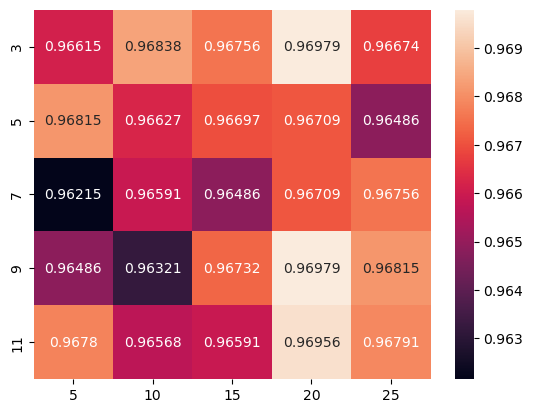

In [156]:
# Plotting results
sns.heatmap(pd.DataFrame(test_results[:,1].reshape(5,5), columns = [5,10,15,20,25], index = [3,5,7,9,11]), annot=True, fmt='.5g')
plt.title('Neural Network Performances')
plt.xlabel('Epochs')
plt.ylabel('Layers')
plt.show()

Here we can see that 3 layers at 20 epochs performs exactly as well as 9 layers at 20 epochs, to several significant figures by some wild coincidence. Since the 3 layer model is simpler, we'll take that one.

333/333 [==============================] - 1s 3ms/step - loss: 3.3783 - accuracy: 0.9564
Time taken: 0.9799745082855225


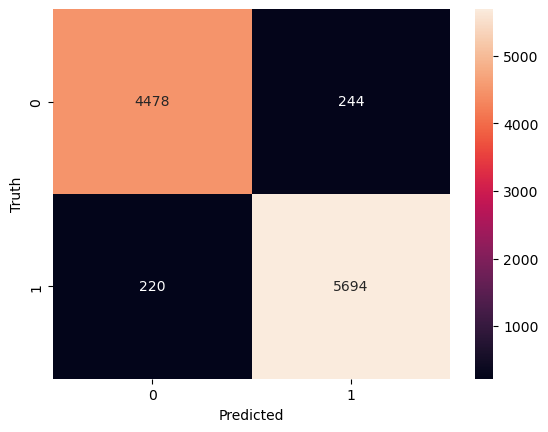



              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4722
           1       0.96      0.96      0.96      5914

    accuracy                           0.96     10636
   macro avg       0.96      0.96      0.96     10636
weighted avg       0.96      0.96      0.96     10636



In [162]:
# Constructing the best model
NN = NN_Model(X_train = X_train_HP, layers = 3, epochs = 20, verbose = 0)
NN.fit(X_train_HP, y_train_HP, epochs=epochs, verbose=0)

# Evaluating against test data
t0 = time.time()
NN.evaluate(X_test_HP, y_test_HP, verbose = 1)
t1 = time.time()
print('Time taken: ' + str(t1-t0))
plot_NN(NN, X_test_HP, y_test_HP)

The neural network performs almost as well as the top two from before, and sits in the middle in terms of time taken (though, with use of a GPU). It is less practical than the Logistic Regression model though, so that one remains king.

The original TF-IDF feature data was selected based on how well Logistic Regression could perform with it, so I'm wondering if these specific features were alwayas going to favor Logistic Regression being the best model here. This could be a study for another time.

# Conclusions

It is notable that we can achieve an accuracy of 96% over this data with the final model. The data is inherently labelled by humans, using language, one of the most complex human contructs in existence. We expect some degree of reduced accuracy because there are import features for distinction that aren't included in the text, such as article appearance, information verity, and the mood the Wikipedia editors on the day they reviewed these articles. That all of this accounts for just 4% misclassified articles is surprising to me, I would have expected at least double, but it seems Wikipedia editors are quite consistent in their judgement. 

Looking at this dataset, the insights between Good and Promotional articles that can be gained here are that Good articles tend to be more formally written, longer, and written on various topics and past events, while Promotional articles tend to be more business oriented, shorter, simpler, and written on more current events. Both classes seem to be written in distinguishable enough styles or with different enough semantics that BERT can easily classify most of them with just small subsets of the larger text.

It should be noted that  "Good" and "Promotional" articles is unlikely to be sufficient in classifying all wikipedia articles. Some articles may just be "okay". However, the model could still probably output a probability that could be used as a measurement for *how* good an article is. Given that "Good" articles tend to be such because they are written in a particular style, "okay" articles could probably be rewritten by machine's such as GPT to at least appear Good. An expansion of this project could include a sample of unlabelled wikipedia articles as either a separate class or a testing dataset.

With more time on this specific project, I might fix the methodological mistake earlier when testing the subsampled models, and write a convenient function that would transform a text and run it through the final logistic regression model for classification. I would also want to test wrong answers between functions, and use the LIME package to see if different machine learning algorithms place different levels of importance on different features.

However, I'm more interested in how well a model could perform on non-wikipedia articles. To really expand on the topic of this project, I would want to see if a model could be trained to identify bias in media based on pressure by corporate doners, as this is far more subtle and far more influential than resumes and articles about various organizations on wikipedia. A more advanced model would seek identify bias in news articles, or news coverage methods. I assume it would be quite difficult to gather this data without making broad assumptions, because of the complexity and potential controversy of the topic. Perhaps if a model was fed with text data from articles and embeddings of what kinds of corporations were sponsoring different media outlets, that could prove interesting.